<a href="https://colab.research.google.com/github/luthfiyahastutiningtyas/Auto-ARIMA-PSO-LSTM-GRU/blob/main/TOWR-Auto_ARIMA%2C_PSO_LSTM_%26_PSO_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Install Library yang Dibutuhkan**

In [ ]:
!pip install pmdarima
!pip install pyswarm
!pip install tensorflow
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=25abc8152a0c8405288fba4f554163702d7726ff4bb5b47c8e7b478c949441ac
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import yfinance as yf
import tensorflow as tf
from scipy import stats
from pmdarima import auto_arima
from pyswarm import pso
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import date, datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Import Data**

In [ ]:
stocks = ["TLKM.JK", "TBIG.JK", "TOWR.JK"]
start_date =  "2014-01-01"
end_date = "2024-01-01"
data = yf.download(stocks, start=start_date, end=end_date)
data.head(5)

[*********************100%%**********************]  3 of 3 completed


Price        Adj Close                            Close                  \
Ticker         TBIG.JK      TLKM.JK     TOWR.JK TBIG.JK TLKM.JK TOWR.JK   
Date                                                                      
2014-01-02  965.110840  1541.423706  429.595886  1210.0  2175.0   540.0   
2014-01-03  957.134644  1505.988647  429.595886  1200.0  2125.0   540.0   
2014-01-06  965.110840  1477.640259  429.595886  1210.0  2085.0   540.0   
2014-01-07  965.110840  1467.010010  426.413635  1210.0  2070.0   536.0   
2014-01-08  989.039062  1488.270996  429.595886  1240.0  2100.0   540.0   

Price         High                     Low                    Open          \
Ticker     TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK   
Date                                                                         
2014-01-02  1210.0  2200.0   540.0  1160.0  2150.0   540.0  1180.0  2175.0   
2014-01-03  1220.0  2175.0   540.0  1160.0  2100.0   540.0  1210.0  2125.0   
2014-01-06  1220.0  2175.0   540.0  1170.0  2065.0   540.0  1220.0  2175.0   
2014-01-07  1215.0  2085.0   536.0  1180.0  2060.0   520.0  1200.0  2085.0   
2014-01-08  1245.0  2100.0   545.0  1200.0  2065.0   534.0  1200.0  2085.0   

Price                 Volume                        
Ticker     TOWR.JK   TBIG.JK     TLKM.JK   TOWR.JK  
Date                                                
2014-01-02   540.0   7512500  44446000.0   50000.0  
2014-01-03   540.0   8992500  60001000.0  280000.0  
2014-01-06   540.0  10958500  81736300.0  610500.0  
2014-01-07   520.0   6029500  73637100.0  212500.0  
2014-01-08   536.0  16130000  84514500.0  246500.0

## **Preprocessing Data**

In [ ]:
df_close = data.Close
list(df_close)
df_close.columns = ['TBIG', 'TLKM', 'TOWR']
df_close.head(5)

,TBIG,TLKM,TOWR
Date,,,
2014-01-02,1210.0,2175.0,540.0
2014-01-03,1200.0,2125.0,540.0
2014-01-06,1210.0,2085.0,540.0
2014-01-07,1210.0,2070.0,536.0
2014-01-08,1240.0,2100.0,540.0


In [ ]:
#statistik deskriptif
df_close.describe()

,TBIG,TLKM,TOWR
count,2482.000000,2481.000000,2481.000000
mean,1622.887591,3617.390165,870.474809
std,677.014073,620.277928,193.823144
min,610.000000,2070.000000,119.199997
25%,1140.000000,3130.000000,755.000000
50%,1325.000000,3760.000000,810.000000
75%,2050.000000,4090.000000,1015.000000
max,3400.000000,4800.000000,1590.000000


In [ ]:
#Periksa tipe data
print(df_close.dtypes)

TBIG    float64
TLKM    float64
TOWR    float64
dtype: object


In [ ]:
# Cek data hilang
data_hilang=df_close.isnull()
missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    1
TOWR    1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2481 non-null   float64
 2   TOWR    2481 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


In [ ]:
from IPython.core.display import clear_output
# Menghapus baris yang mengandung nilai NaN
modus_tlkm = df_close['TLKM'].mode()[0]
df_close['TLKM'].fillna(modus_tlkm, inplace=True)
modus_towr = df_close['TOWR'].mode()[0]
df_close['TOWR'].fillna(modus_towr, inplace=True)

clear_missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {clear_missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    0
TOWR    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2482 non-null   float64
 2   TOWR    2482 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


<ipython-input-8-9cb536d8d3f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TLKM'].fillna(modus_tlkm, inplace=True)
<ipython-input-8-9cb536d8d3f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TOWR'].fillna(modus_towr, inplace=True)


In [ ]:
# Periksa apakah ada tanggal yang duplikat
duplicate_dates = df_close[df_close.index.duplicated(keep=False)]
print("Tanggal duplikat:\n", duplicate_dates)

Tanggal duplikat:
 Empty DataFrame
Columns: [TBIG, TLKM, TOWR]
Index: []


In [ ]:
index_to_change = '2018-05-02'

# Mengubah nilai pada indeks tertentu
df_close.loc[index_to_change, 'TOWR'] = 604

index_to_change = '2018-05-04'

# Mengubah nilai pada indeks tertentu
df_close.loc[index_to_change, 'TOWR'] = 596


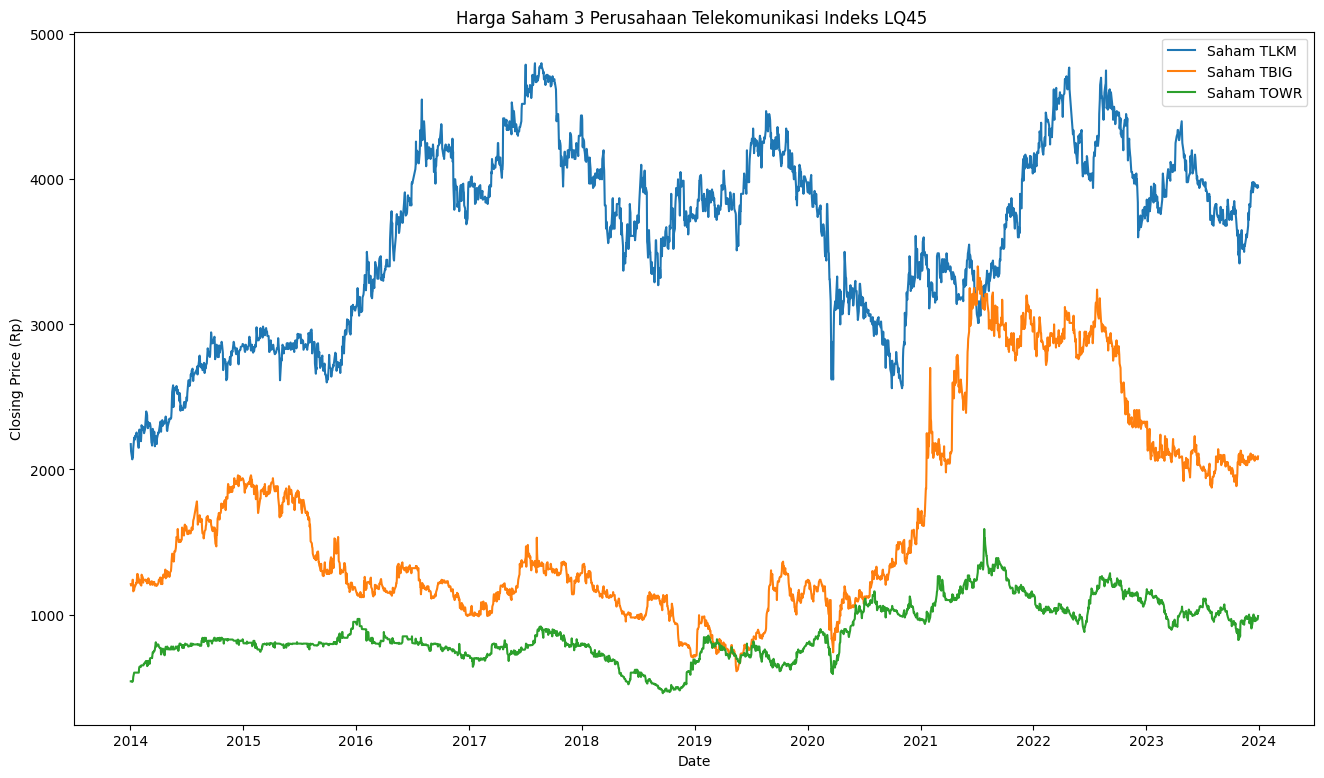

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(16,9))
for name in ['TLKM', 'TBIG', 'TOWR']:
    ax.plot(df_close[name].index, df_close[name], label='Saham {}'.format(name))

ax.set_title('Harga Saham 3 Perusahaan Telekomunikasi Indeks LQ45 ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (Rp)')
ax.legend()

In [ ]:
split_data = df_close.shape[0] * 0.8

df_train = df_close[:int(split_data)]
df_test = df_close[int(split_data):]

#Checking dataset shape
print("df_train: ", df_train.shape)
print(df_train)
print("df_test: ", df_test.shape)
print(df_test)

df_train:  (1985, 3)
              TBIG    TLKM    TOWR
Date                              
2014-01-02  1210.0  2175.0   540.0
2014-01-03  1200.0  2125.0   540.0
2014-01-06  1210.0  2085.0   540.0
2014-01-07  1210.0  2070.0   536.0
2014-01-08  1240.0  2100.0   540.0
...            ...     ...     ...
2021-12-08  3080.0  4090.0  1130.0
2021-12-09  3180.0  4150.0  1135.0
2021-12-10  3200.0  4150.0  1145.0
2021-12-13  3140.0  4080.0  1145.0
2021-12-14  3100.0  4100.0  1125.0

[1985 rows x 3 columns]
df_test:  (497, 3)
              TBIG    TLKM    TOWR
Date                              
2021-12-15  3090.0  4080.0  1130.0
2021-12-16  3130.0  4100.0  1120.0
2021-12-17  3090.0  4100.0  1115.0
2021-12-20  3090.0  4080.0  1140.0
2021-12-21  3040.0  4160.0  1140.0
...            ...     ...     ...
2023-12-21  2070.0  3950.0   955.0
2023-12-22  2080.0  3960.0   965.0
2023-12-27  2080.0  3940.0   965.0
2023-12-28  2070.0  3960.0   970.0
2023-12-29  2090.0  3950.0   990.0

[497 rows x 3 columns]


In [ ]:
df_train

,TBIG,TLKM,TOWR
Date,,,
2014-01-02,1210.0,2175.0,540.0
2014-01-03,1200.0,2125.0,540.0
2014-01-06,1210.0,2085.0,540.0
2014-01-07,1210.0,2070.0,536.0
2014-01-08,1240.0,2100.0,540.0
...,...,...,...
2021-12-08,3080.0,4090.0,1130.0
2021-12-09,3180.0,4150.0,1135.0
2021-12-10,3200.0,4150.0,1145.0


---
# **PT. Sarana Menara Nusantara Tbk (TOWR)**
---

###**Splitting Data**

In [ ]:
#Split Dataset Training 80% & Testing 20%
data_towr = df_close['TOWR']
data_towr.index=data_towr.index.date
split_data = data_towr.shape[0] * 0.8

df_train_towr = data_towr[:int(split_data)]
df_test_towr = data_towr[int(split_data):]

#Checking dataset shape
print("df_train_towr: ", df_train_towr.shape)
print(df_train_towr)
print("df_test_towr: ", df_test_towr.shape)
print(df_test_towr)

df_train_towr:  (1985,)
2014-01-02     540.0
2014-01-03     540.0
2014-01-06     540.0
2014-01-07     536.0
2014-01-08     540.0
               ...  
2021-12-08    1130.0
2021-12-09    1135.0
2021-12-10    1145.0
2021-12-13    1145.0
2021-12-14    1125.0
Name: TOWR, Length: 1985, dtype: float64
df_test_towr:  (497,)
2021-12-15    1130.0
2021-12-16    1120.0
2021-12-17    1115.0
2021-12-20    1140.0
2021-12-21    1140.0
               ...  
2023-12-21     955.0
2023-12-22     965.0
2023-12-27     965.0
2023-12-28     970.0
2023-12-29     990.0
Name: TOWR, Length: 497, dtype: float64


---
## **Auto ARIMA**
---

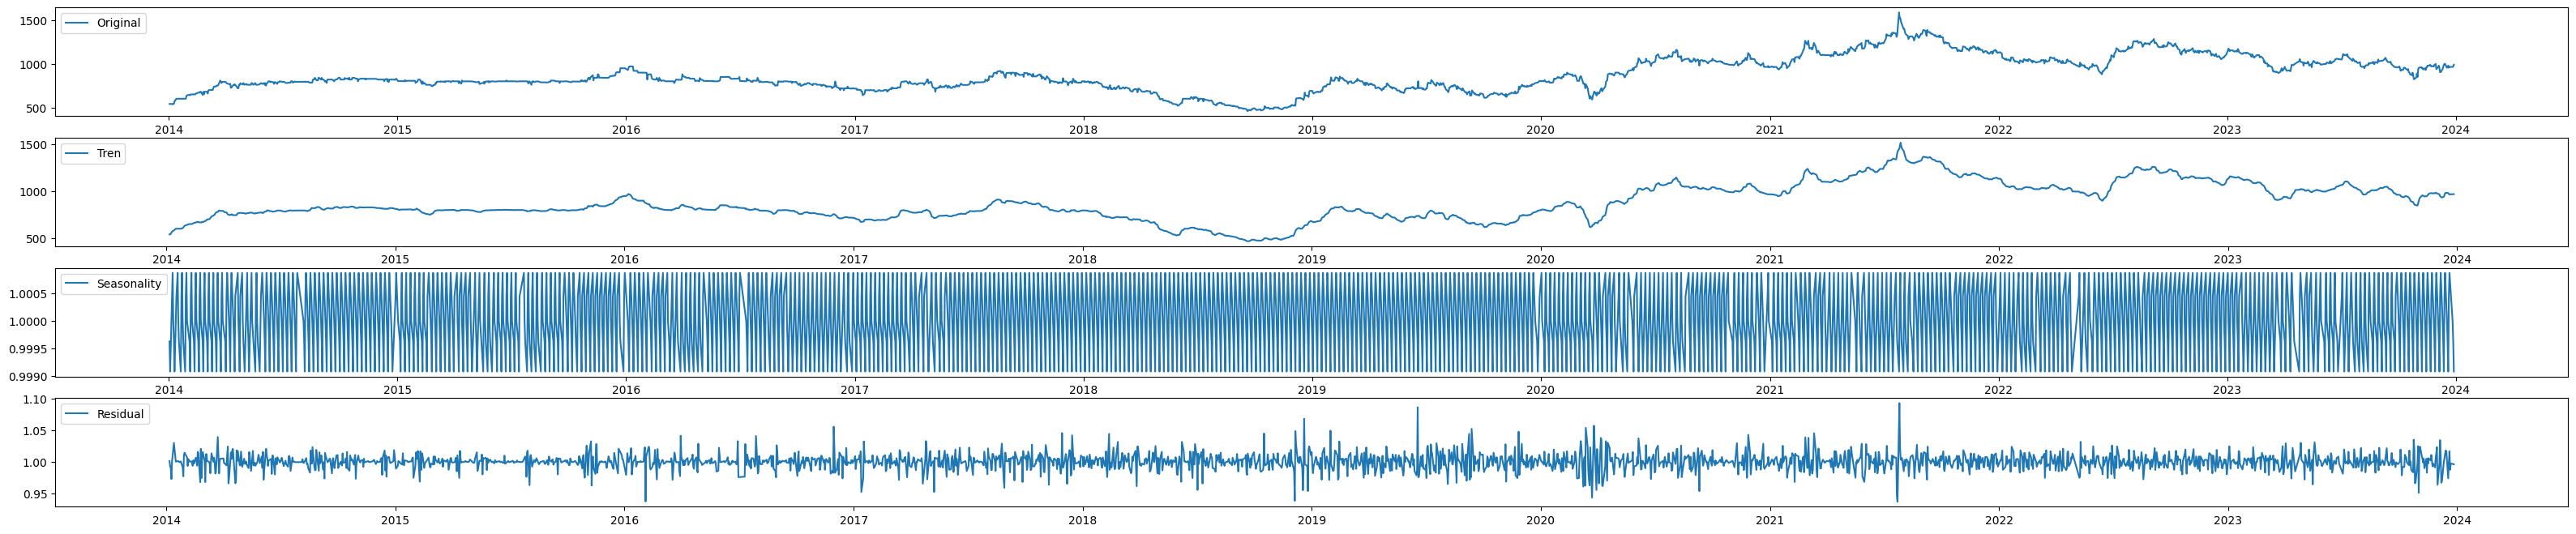

In [ ]:
#Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(data_towr, model='multiplicative', period=5)  # Atau 'multiplicative'
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid
fig, ax = plt.subplots(4, 1, figsize=(40, 8))
ax[0].plot(data_towr, label='Original')
ax[0].legend(loc='upper left')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='upper left')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='upper left')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='upper left')
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(data_towr, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                   -2.251438
p-value                           0.188109
#Lags Used                        2.000000
Number of Observations Used    2479.000000
Critical Value (1%)              -3.432991
Critical Value (5%)              -2.862707
Critical Value (10%)             -2.567391
dtype: float64


p-value sebesar 0.188109 lebih dari 0.05 maka data tidak stasioner

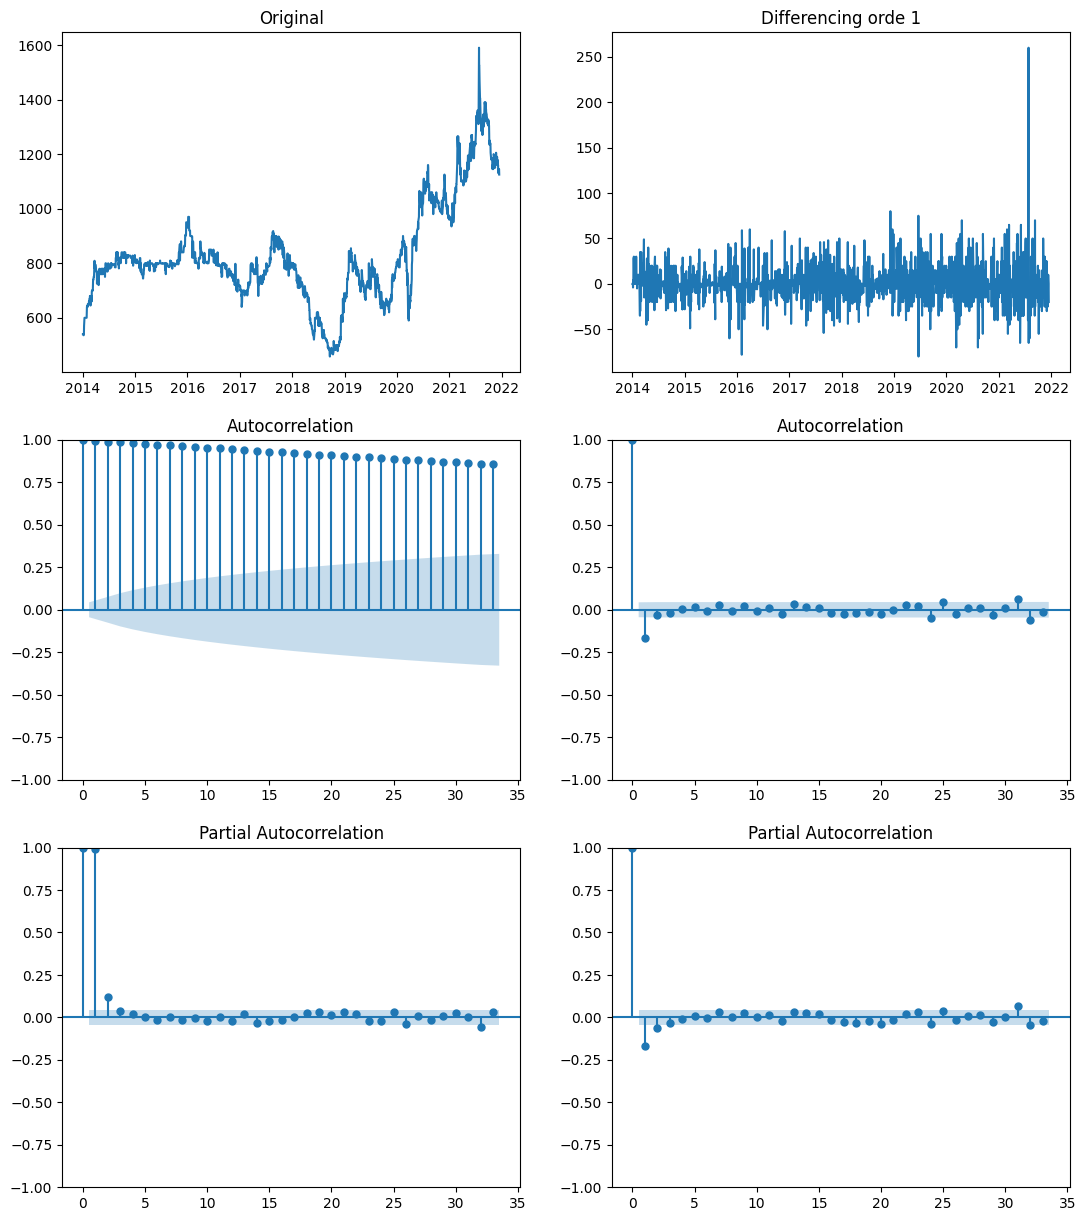

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(13,15))
axes[0, 0].plot(df_train_towr)
axes[0, 0].set_title('Original')
#Differencing orde 1
axes[0, 1].plot(df_train_towr.diff())
axes[0, 1].set_title('Differencing orde 1')

#ACF plot untuk menentukan q (MA)
plot_acf(df_train_towr, ax=axes[1, 0])
plot_acf(df_train_towr.diff().dropna(), ax=axes[1, 1])

#PACF plot untuk menentukan p (AR)
plot_pacf(df_train_towr, ax=axes[2,0])
plot_pacf(df_train_towr.diff().dropna(), ax=axes[2,1])

plt.show()

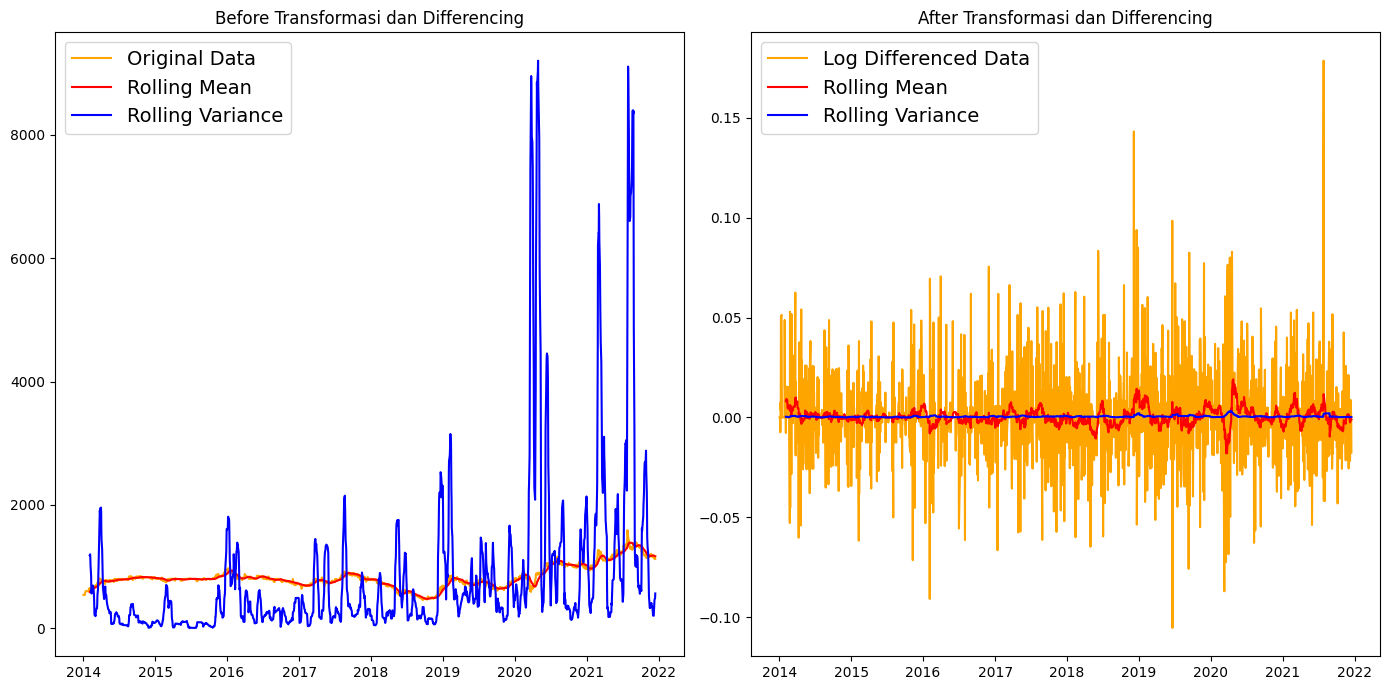

In [ ]:
#Rolling mean dan rolling varians
rolling_mean = df_train_towr.rolling(21).mean()
rolling_var = df_train_towr.rolling(21).var()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(df_train_towr, color='orange', label='Original Data')
ax[0].plot(rolling_mean, color='red', label='Rolling Mean')
ax[0].plot(rolling_var, color='blue', label='Rolling Variance')
ax[0].set_title('Before Transformasi dan Differencing')
ax[0].legend(loc='upper left', fontsize=14)

# Transformasi logaritmik
data_log = np.log(df_train_towr)
data_log_diff = data_log.diff().dropna()

#Rolling mean dan rolling varians
rolling_mean = data_log_diff.rolling(21).mean()
rolling_var = data_log_diff.rolling(21).var()

ax[1].plot(data_log_diff, color='orange', label='Log Differenced Data')
ax[1].plot(rolling_mean, color='red', label='Rolling Mean')
ax[1].plot(rolling_var, color='blue', label='Rolling Variance')
ax[1].set_title('After Transformasi dan Differencing')
ax[1].legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#Differencing orde 1
df_test = adfuller(data_log_diff, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                  -35.848104
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1982.000000
Critical Value (1%)              -3.433654
Critical Value (5%)              -2.862999
Critical Value (10%)             -2.567547
dtype: float64


p-value sebesar 0.0000 kurang dari 0.05 maka data stasioner

In [ ]:
start_time = time.time()
Model_auto_arima = auto_arima(data_log,
                                 trace=True,
                                 stepwise=True,
                                 error_action='ignore',
                                 supress_warnings=True,
                                 seasonal=False,
                                 stationary=False,
                                 start_p=0,
                                 start_q=0,
                                 d=1,
                                 max_p=5,
                                 max_q=5,
                                 method='bfgs'
                                 )
end_time = time.time()
Model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9673.426, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9734.027, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9738.758, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9674.817, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9737.458, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9737.458, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9735.367, Time=3.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9739.791, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9738.451, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9738.454, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9735.152, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9736.385, Time=3.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 11.652 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1985
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4871.895
Date:                Tue, 13 Aug 2024   AIC                          -9739.791
Time:                        04:15:39   BIC                          -9728.605
Sample:                             0   HQIC                         -9735.682
                               - 1985                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1888      0.016    -11.736      0.000      -0.220      -0.157
sigma2         0.0004   6.62e-06     65.168      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3696.89
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fitted = Model_auto_arima.predict_in_sample()
fitted_values = np.exp(fitted)

In [ ]:
import statsmodels.api as sm
residuals = Model_auto_arima.resid()
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[2], return_df=True)
print('Ljung-Box Test Results:')
print(ljung_box_results)

Ljung-Box Test Results:
    lb_stat  lb_pvalue
2  0.000408   0.999796


Nilai lb_pvalue sebesar 0.998178 lebih besar dari 0.05 menunjukkan bahwa model Auto ARIMA berhasil menangkap semua pola dalam data, dan residual dari model tersebut adalah white noise.

In [ ]:
prediksi = Model_auto_arima.predict(n_periods= len(df_test_towr))
prediksi_autoarima = np.exp(prediksi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


####**Evaluasi Model**



In [ ]:
#Evaluasi Train Data
r2_train_autoarima = r2_score(df_train_towr, fitted_values)
rmse_train_autoarima = np.sqrt(mse(df_train_towr, fitted_values))
mape_train_autoarima = mape(df_train_towr, fitted_values) * 100
print('R2 pada Train Data :', r2_train_autoarima)
print('RMSE pada Train Data :', rmse_train_autoarima)
print('MAPE pada Train Data :', mape_train_autoarima)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_autoarima = r2_score(df_test_towr, prediksi_autoarima)
rmse_test_autoarima = np.sqrt(mse(df_test_towr, prediksi_autoarima))
mape_test_autoarima = mape(df_test_towr, prediksi_autoarima) * 100
print('R2 pada Train Data :', r2_test_autoarima)
print('RMSE pada Train Data :', rmse_test_autoarima)
print('MAPE pada Train Data :', mape_test_autoarima)
print("------------------------------------------")
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9862500215760815
RMSE pada Train Data : 21.48055776128213
MAPE pada Train Data : 1.3651878080420496
------------------------------------------
R2 pada Train Data : -0.6095160643114892
RMSE pada Train Data : 118.60039963661767
MAPE pada Train Data : 9.988069357388554
------------------------------------------
Training time: 11.664613008499146


####**Comparison Real vs Prediction**

In [ ]:
tabel_fitted_autoarima = pd.DataFrame({'Date': df_train_towr.index,  'Data Train': df_train_towr.values, 'Fitted Values':  fitted_values})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_towr_fitted.csv'
tabel_fitted_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_towr_fitted.csv')
tabel_fitted_autoarima

,Date,Data Train,Fitted Values
0,2014-01-02,540.0,1.000000
1,2014-01-03,540.0,540.000000
2,2014-01-06,540.0,540.000000
3,2014-01-07,536.0,540.000000
4,2014-01-08,540.0,536.752957
...,...,...,...
1980,2021-12-08,1130.0,1139.779993
1981,2021-12-09,1135.0,1131.840175
1982,2021-12-10,1145.0,1134.402698
1983,2021-12-13,1145.0,1142.991502


In [ ]:
tabel_prediksi_autoarima = pd.DataFrame({'Date':df_test_towr.index, 'Test' : df_test_towr.values, 'Prediksi Auto ARIMA': prediksi_autoarima})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_towr_results.csv'
tabel_prediksi_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_towr_results.csv')
tabel_prediksi_autoarima

,Date,Test,Prediksi Auto ARIMA
0,2021-12-15,1130.0,1128.678738
1,2021-12-16,1120.0,1128.678738
2,2021-12-17,1115.0,1128.678738
3,2021-12-20,1140.0,1128.678738
4,2021-12-21,1140.0,1128.678738
...,...,...,...
492,2023-12-21,955.0,1128.678738
493,2023-12-22,965.0,1128.678738
494,2023-12-27,965.0,1128.678738
495,2023-12-28,970.0,1128.678738


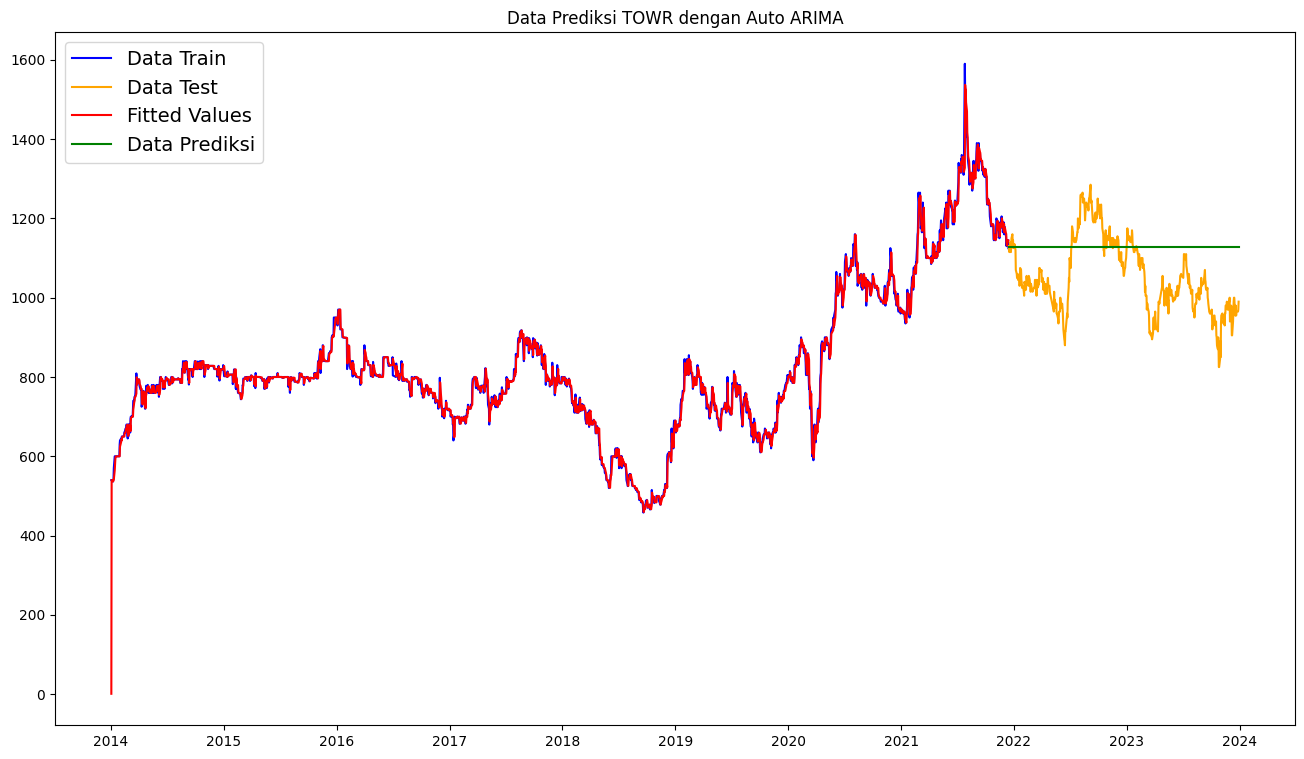

In [ ]:
#Plot data prediksi
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="blue", label='Data Train')
plt.plot(df_test_towr, color="orange", label='Data Test')
plt.plot(df_train_towr.index, fitted_values, color="red", label='Fitted Values')
plt.plot(df_test_towr.index, prediksi_autoarima, color="green",  label='Data Prediksi')
plt.title('Data Prediksi TOWR dengan Auto ARIMA')
plt.legend(loc="upper left", fontsize=14)

plot_auto_arima = '/content/drive/My Drive/skripsi/auto arima/auto_arima_towr.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_auto_arima)
plt.show()


---
## **LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_towr, df_test_towr):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_towr_norm = scaler.fit_transform(df_train_towr.values.reshape(-1,1))
  test_data_towr_norm = scaler.transform(df_test_towr.values.reshape(-1,1))
  return scaler, train_data_towr_norm, test_data_towr_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_towr_norm, test_data_towr_norm = normalize_data(df_train_towr, df_test_towr)

In [ ]:
tabel_data_train_norm_towr = pd.DataFrame(train_data_towr_norm, columns=['Data Train Normalisasi'], index=df_train_towr.index)
tabel_data_train_norm_towr

,Data Train Normalisasi
2014-01-02,0.072438
2014-01-03,0.072438
2014-01-06,0.072438
2014-01-07,0.068905
2014-01-08,0.072438
...,...
2021-12-08,0.593640
2021-12-09,0.598057
2021-12-10,0.606890
2021-12-13,0.606890


In [ ]:
tabel_data_test_norm_towr = pd.DataFrame(test_data_towr_norm, columns=['Data Test Normalisasi'], index=df_test_towr.index)
tabel_data_test_norm_towr

,Data Test Normalisasi
2021-12-15,0.593640
2021-12-16,0.584806
2021-12-17,0.580389
2021-12-20,0.602473
2021-12-21,0.602473
...,...
2023-12-21,0.439046
2023-12-22,0.447880
2023-12-27,0.447880
2023-12-28,0.452297


####**Hyperparameter Tuning**

In [ ]:
params = (10, 25, 10, 64)
window_size_lstm = int(params[0])
hidden_layer_lstm = int( params[1])
epochs_lstm = int( params[2])
batch_size_lstm = int( params[3])
print('Window size: ', window_size_lstm)
print('Hidden layer: ', hidden_layer_lstm)
print('Epoch: ', epochs_lstm)
print('Batch size: ', batch_size_lstm)

Window size:  10
Hidden layer:  25
Epoch:  10
Batch size:  64


In [ ]:
X_train_lstm, Y_train_lstm = prepare_dataset(train_data_towr_norm, window_size_lstm)
X_test_lstm, Y_test_lstm = prepare_dataset(test_data_towr_norm, window_size_lstm)
print("X_train: ", X_train_lstm.shape)
print("Y_train: ", Y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("Y_test", Y_test_lstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#LSTM model
start_time = time.time()
final_model_lstm = Sequential()

# Layer Input
final_model_lstm.add(Input(shape=(X_train_lstm.shape[1], 1)))

# Layer LSTM dan Dropout
final_model_lstm.add(LSTM(units=int(hidden_layer_lstm), activation='tanh', dropout=0.2, return_sequences=False))
final_model_lstm.add(Dense(units=1))

# Kompilasi model
optimizer = Adam(learning_rate=0.0001)
final_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model
final_model_lstm.fit(X_train_lstm, Y_train_lstm, epochs=int(epochs_lstm), batch_size=int(batch_size_lstm),
                     validation_data=(X_test_lstm, Y_test_lstm), callbacks=[early_stopping])
end_time = time.time()
#Predictions
y_train_pred_lstm = final_model_lstm.predict(X_train_lstm)
y_test_pred_lstm = final_model_lstm.predict(X_test_lstm)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0873 - val_loss: 0.1375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0562 - val_loss: 0.0914
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397 - val_loss: 0.0560
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0275 - val_loss: 0.0323
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - val_loss: 0.0189
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160 - val_loss: 0.0133
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0183 - val_loss: 0.0112
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0154 - val_loss: 0.0117
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.reshape(-1,1))
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.reshape(-1,1))
Y_train_lstm = scaler.inverse_transform(Y_train_lstm.reshape(-1,1))
Y_test_lstm = scaler.inverse_transform(Y_test_lstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:

#Evaluasi Train Data
r2_train_lstm = r2_score(Y_train_lstm, y_train_pred_lstm)
rmse_train_lstm = np.sqrt(mse(Y_train_lstm, y_train_pred_lstm))
mape_train_lstm = mape(Y_train_lstm, y_train_pred_lstm) * 100
print('R2 pada Train Data :', r2_train_lstm)
print('RMSE pada Train Data :', rmse_train_lstm)
print('MAPE pada Train Data :', mape_train_lstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_lstm = r2_score(Y_test_lstm, y_test_pred_lstm)
rmse_test_lstm = np.sqrt(mse(Y_test_lstm, y_test_pred_lstm))
mape_test_lstm = mape(Y_test_lstm, y_test_pred_lstm) * 100
print('R2 pada Test Data :', r2_test_lstm)
print('RMSE pada Test Data :', rmse_test_lstm)
print('MAPE pada Test Data :', mape_test_lstm)
print("Training time: "  + str(end_time - start_time))

In [ ]:
params_lstm = {
    'Window Size': window_size_lstm,
    'Hidden Layers': hidden_layer_lstm,
    'Epochs': epochs_lstm,
    'Batch Size': batch_size_lstm,
    'R2 Train': r2_train_lstm,
    'RMSE Train': rmse_train_lstm,
    'MAPE Train': mape_train_lstm,
    'R2 Test': r2_test_lstm,
    'RMSE Test': rmse_test_lstm,
    'MAPE Test': mape_test_lstm
}

results_lstm = pd.DataFrame([params_lstm])
folder_lstm = '/content/drive/My Drive/skripsi/lstm/towr/lstm_results.csv'
results_lstm.to_csv(folder_lstm, index=False, mode='a', header=False)
results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/towr/lstm_results.csv')
results_lstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.867797,66.840445,46.313268,6.154528,0.228324,82.393360,72.398970,6.649889
1,10,50,10,32,0.882845,62.921521,42.295018,5.616402,0.270886,80.088874,69.501745,6.407421
2,15,25,10,32,0.891074,60.632578,42.511711,5.691017,0.460277,69.013475,57.877025,5.305960
3,15,50,10,32,0.913273,54.102658,37.108530,5.050751,0.580598,60.836447,50.319848,4.643440
4,20,25,10,32,0.879255,63.809668,46.341643,6.284630,0.476870,68.261703,56.757114,5.205382
5,20,50,10,32,0.943047,43.823892,30.212063,4.273980,0.796288,42.597112,32.957487,3.117187


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_lstm = data_towr[window_size_lstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_lstm.index,  'Data Train': data_train_lstm.values})
prediksi_train_lstm = pd.DataFrame({'Prediksi Data Train LSTM':  y_train_pred_lstm.flatten()})
tabel_prediksi_train_lstm = pd.concat([tabel_data_train, prediksi_train_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/towr/train/lstm_6.csv'
tabel_prediksi_train_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_train_lstm

,Date,Data Train,Prediksi Data Train LSTM
0,2014-01-20,600.0,658.933472
1,2014-01-21,600.0,662.928467
2,2014-01-22,600.0,666.752930
3,2014-01-23,600.0,670.306885
4,2014-01-24,600.0,673.679077
...,...,...,...
1969,2021-12-08,1130.0,1014.646118
1970,2021-12-09,1135.0,1011.568665
1971,2021-12-10,1145.0,1008.104187
1972,2021-12-13,1145.0,1004.654846


In [ ]:
split_data = data_towr.shape[0] * 0.8
data_test_lstm = data_towr[window_size_lstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_lstm.index, 'Data Test': data_test_lstm.values})
prediksi_test_lstm = pd.DataFrame({'Prediksi Data Test LSTM':  y_test_pred_lstm.flatten()})
tabel_prediksi_test_lstm = pd.concat([tabel_data_test, prediksi_test_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/towr/test/lstm_6.csv'
tabel_prediksi_test_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_test_lstm

,Date,Data Test,Prediksi Data Test LSTM
0,2022-01-14,1045.0,1086.380127
1,2022-01-17,1050.0,1080.794800
2,2022-01-18,1045.0,1075.147095
3,2022-01-19,1030.0,1069.847778
4,2022-01-20,1035.0,1064.499390
...,...,...,...
471,2023-12-21,955.0,957.918152
472,2023-12-22,965.0,958.896667
473,2023-12-27,965.0,958.881653
474,2023-12-28,970.0,958.722229


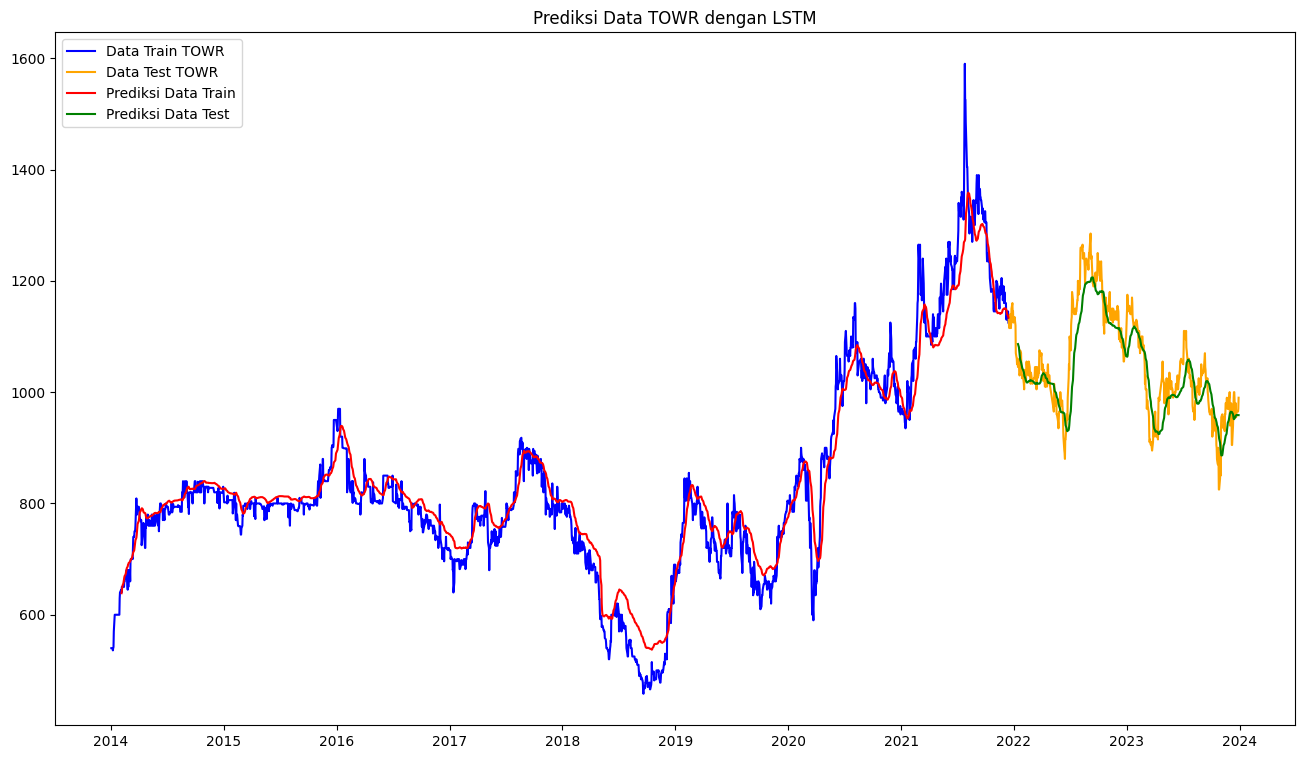

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_lstm = data_towr[20 + 1:int(split_data)]
data_test_lstm = data_towr[20 + 1 + int(split_data):]

#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="blue", label='Data Train TOWR')
plt.plot(df_test_towr, color="orange", label='Data Test TOWR')
plt.plot(data_train_lstm.index, y_train_pred_lstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_lstm.index, y_test_pred_lstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TOWR dengan LSTM')
plt.legend(loc="upper left")
plot_lstm = '/content/drive/My Drive/skripsi/lstm/towr/plot_lstm_6.png'
plt.savefig(plot_lstm)
plt.show()

---
## **PSO-LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_towr, df_test_towr):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_towr_norm = scaler.fit_transform(df_train_towr.values.reshape(-1,1))
  test_data_towr_norm = scaler.transform(df_test_towr.values.reshape(-1,1))
  return scaler, train_data_towr_norm, test_data_towr_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-LSTM**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_lstm(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params
  print('window_size', window_size, ', hidden_layers', hidden_layers,
        ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #LSTM model
  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], 1)))
  model.add(LSTM(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_towr_norm, test_data_towr_norm = normalize_data(df_train_towr, df_test_towr)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_towr_norm, lb[0])
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_towr_norm, lb[0])
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psolstm, best_value_psolstm = pso(objective_function_lstm, lb, ub, args=(X_train_psolstm, Y_train_psolstm, scaler, X_test_psolstm, Y_test_psolstm), swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psolstm)
print('RMSE:', best_value_psolstm)

window_size 16.215018638503096 , hidden_layers 43.22269184295561 , epochs 7.881175626795959 , batch_size 14.733184096530248
Epoch 1/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1186 - val_loss: 0.0577
Epoch 2/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0167 - val_loss: 0.0128
Epoch 3/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 4/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 5/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 6/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0135 - val_loss: 0.0148
Epoch 7/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0138 - val_loss: 0.0131
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation RMSE:  0.08116058385266431 

window_size 16.465306124738632 , hidden_layers 37.59786372034159 , epochs 6.816982316315902 , batch_size 21.98871831213069
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0666 - val_loss: 0.0435
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234 - val_loss: 0.0111
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156 - val_loss: 0.0110
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153 - val_loss: 0.0133
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0149 - val_loss: 0.0140
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation RMSE:  0.07317144770899703 

window_size 14.382184535119286 , hidden_layers 49.66141958112823 , epochs 9.515682391505518 , batch_size 19.01234022231196
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0712 - val_loss: 0.0301
Epoch 2/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0163 - val_loss: 0.0112
Epoch 3/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 4/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0163 - val_loss: 0.0117
Epoch 5/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155 - val_loss: 0.0139
Epoch 6/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 7/9
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0150 - val_loss: 0.0131
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07075937093842537 

window_size 17.128034363094788 , hidden_layers 32.62609626924958 , epochs 4.422235119625319 , batch_size 17.618548484615275
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0970 - val_loss: 0.0758
Epoch 2/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0251 - val_loss: 0.0132
Epoch 3/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 4/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0156 - val_loss: 0.0132
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.0749493761984505 

window_size 10.526396051596922 , hidden_layers 28.959980866453442 , epochs 6.729835711754946 , batch_size 2.4718767006773907
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0495 - val_loss: 0.0158
Epoch 2/6
987/987 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0147 - val_loss: 0.0186
Epoch 3/6
987/987 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 4/6
987/987 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0101 - val_loss: 0.0187
Epoch 5/6
987/987 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0096 - val_loss: 0.0148
Epoch 6/6
987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0084 - val_loss: 0.0124
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.0874887580696745 

window_size 15.805935022194474 , hidden_layers 39.349531179016225 , epochs 7.133510070146384 , batch_size 10.902871824443714
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1104 - val_loss: 0.0268
Epoch 2/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0171 - val_loss: 0.0121
Epoch 3/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 4/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127 - val_loss: 0.0147
Epoch 5/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 6/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - val_loss: 0.0134
Epoch 7/7
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - val_loss: 0.0134
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation RMSE:  0.08511354526038287 

window_size 17.666745937327892 , hidden_layers 42.504256106511136 , epochs 6.647084478198516 , batch_size 22.36049657016196
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0926 - val_loss: 0.0644
Epoch 2/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0243 - val_loss: 0.0124
Epoch 3/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 4/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0154 - val_loss: 0.0135
Epoch 5/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0138
Epoch 6/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149 - val_loss: 0.0149
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07735379303685115 

window_size 13.233838948791352 , hidden_layers 46.26930481192791 , epochs 10.0 , batch_size 27.815431362153877
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1337 - val_loss: 0.1602
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0523 - val_loss: 0.0386
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0180 - val_loss: 0.0129
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 0.0142
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.08600625955449492 

window_size 18.115725660705216 , hidden_layers 35.70355441547071 , epochs 10.0 , batch_size 4.231436612067455
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1018 - val_loss: 0.0150
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 3/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0130 - val_loss: 0.0157
Epoch 4/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0121 - val_loss: 0.0169
Epoch 5/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0165
Epoch 6/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0114 - val_loss: 0.0220
Epoch 7/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0097 - val_loss: 0.0174
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation RMSE:  0.08465318934506001 

window_size 10.0 , hidden_layers 38.12753869868001 , epochs 6.481391945563642 , batch_size 9.21343840940506
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0471 - val_loss: 0.0115
Epoch 2/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0131
Epoch 3/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0151 - val_loss: 0.0156
Epoch 4/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0117 - val_loss: 0.0170
Epoch 5/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 6/6
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0131 - val_loss: 0.0152
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07126288481577245 

window_size 15.370133349915118 , hidden_layers 39.719396381025675 , epochs 7.678631189109039 , batch_size 9.411881886437516
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0779 - val_loss: 0.0138
Epoch 2/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 3/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 4/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - val_loss: 0.0140
Epoch 5/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0110 - val_loss: 0.0150
Epoch 6/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 7/7
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0135 - val_loss: 0.0194
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.08151681088462137 

window_size 17.404707768492823 , hidden_layers 46.19519317208801 , epochs 7.441548053195698 , batch_size 20.814633872819677
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1374 - val_loss: 0.1172
Epoch 2/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0334 - val_loss: 0.0143
Epoch 3/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0166 - val_loss: 0.0137
Epoch 4/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0146
Epoch 5/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0121 - val_loss: 0.0135
Epoch 6/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0139
Epoch 7/7
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0154 - val_loss: 0.0137
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation RMSE:  0.08421582186703587 

window_size 13.47513795906559 , hidden_layers 45.11220425250968 , epochs 10.0 , batch_size 28.73304738046054
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0796 - val_loss: 0.0675
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0301 - val_loss: 0.0143
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0143 - val_loss: 0.0119
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0151 - val_loss: 0.0125
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0165 - val_loss: 0.0120
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - val_loss: 0.0146
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143 - val_loss: 0.0131
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07180874501176021 

window_size 16.612974027103252 , hidden_layers 38.48601773341057 , epochs 10.0 , batch_size 1.0
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1974/1974 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0334 - val_loss: 0.0229
Epoch 2/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0101 - val_loss: 0.0219
Epoch 3/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0104 - val_loss: 0.0152
Epoch 4/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0094 - val_loss: 0.0117
Epoch 5/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 6/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0067 - val_loss: 0.0108
Epoch 7/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 8/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0071 - val_loss: 0.0123
Epoch 9/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 10/10
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0066 - val_loss: 0.0124
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.0704548032891967 

wind

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1113 - val_loss: 0.0229
Epoch 2/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 3/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0118 - val_loss: 0.0145
Epoch 4/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127 - val_loss: 0.0148
Epoch 5/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 6/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 7/7
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0139 - val_loss: 0.0153
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.08744887351346134 

window_size 15.489513187843412 , hidden_layers 41.06741738651841 , epochs 8.345167091966896 , batch_size 8.707718408686429
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0615 - val_loss: 0.0117
Epoch 2/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0171 - val_loss: 0.0138
Epoch 3/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0145 - val_loss: 0.0118
Epoch 4/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 5/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 6/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0114 - val_loss: 0.0159
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07400028752340487 

window_size 16.718380755392815 , hidden_layers 42.5990997188683 , epochs 8.83631208724826 , batch_size 18.48792488806275
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1208 - val_loss: 0.0992
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0306 - val_loss: 0.0134
Epoch 3/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156 - val_loss: 0.0136
Epoch 4/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 5/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 6/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 7/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0124 - val_loss: 0.0141
Epoch 8/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0128 - val_loss: 0.0152
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation RMSE:  0.0836242169564399 

window_size 14.402263304889157 , hidden_layers 43.361919213203436 , epochs 9.872025022060463 , batch_size 25.916991817207105
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0759 - val_loss: 0.0615
Epoch 2/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0249 - val_loss: 0.0116
Epoch 3/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0149 - val_loss: 0.0099
Epoch 4/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0161 - val_loss: 0.0114
Epoch 5/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - val_loss: 0.0107
Epoch 6/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - val_loss: 0.0129
Epoch 7/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 8/9
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0144
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.06954121590487086 

window_size 15.524107658657227 , hidden_layers 39.87876808373016 , epochs 10.0 , batch_size 2.439339419921869
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0397 - val_loss: 0.0176
Epoch 2/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0152 - val_loss: 0.0110
Epoch 3/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0088 - val_loss: 0.0152
Epoch 4/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0085 - val_loss: 0.0155
Epoch 5/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0091 - val_loss: 0.0159
Epoch 6/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0086 - val_loss: 0.0114
Epoch 7/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 8/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0069 - val_loss: 0.0134
Epoch 9/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 10/10
987/987 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0122
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07900918061839182 

window_size 11.066090923640456 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1488 - val_loss: 0.0646
Epoch 2/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0193 - val_loss: 0.0146
Epoch 3/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 5/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0126 - val_loss: 0.0133
Epoch 6/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 7/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0128 - val_loss: 0.0148
Epoch 8/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0127 - val_loss: 0.0152
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.08407526363726535 

window_size 15.536267637685295 , hidden_layers 41.94402577663269 , epochs 9.035678944324783 , batch_size 11.32614548510463
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1238 - val_loss: 0.0525
Epoch 2/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0166 - val_loss: 0.0140
Epoch 3/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 4/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0150 - val_loss: 0.0120
Epoch 5/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - val_loss: 0.0145
Epoch 6/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 7/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - val_loss: 0.0141
Epoch 8/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126 - val_loss: 0.0149
Epoch 9/9
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127 - val_loss: 0.0183
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation RMSE:  0.08461340337785704 

window_size 15.941192721950703 , hidden_layers 40.69312075853201 , epochs 8.825045893733742 , batch_size 22.172943516590138


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0955 - val_loss: 0.0739
Epoch 2/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0276 - val_loss: 0.0111
Epoch 3/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 4/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 5/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 6/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 7/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0139 - val_loss: 0.0137
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.0708937599269274 

window_size 14.86582597780094 , hidden_layers 42.48677669355031 , epochs 9.808037533090694 , batch_size 24.508964035580387
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0985 - val_loss: 0.0840
Epoch 2/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0317 - val_loss: 0.0147
Epoch 3/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 4/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 5/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0180 - val_loss: 0.0132
Epoch 6/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 7/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 8/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0137 - val_loss: 0.0145
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.07520081216061826 

window_size 15.041921499018146 , hidden_layers 41.6612411466703 , epochs 10.0 , batch_size 14.124061907724894
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1104 - val_loss: 0.0590
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0196 - val_loss: 0.0117
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0124 - val_loss: 0.0144
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0137 - val_loss: 0.0148
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07722022910663942 

window_size 11.96263012532997 , hidden_layers 44.73240743045335 , epochs 8.721928565937485 , batch_size 19.107140311944146
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1339 - val_loss: 0.0959
Epoch 2/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0285 - val_loss: 0.0140
Epoch 3/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 4/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 5/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 6/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0131 - val_loss: 0.0146
Epoch 7/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.0143
Epoch 8/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0151
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation RMSE:  0.08387570627569928 

window_size 15.519482618326768 , hidden_layers 42.42336607673741 , epochs 9.381524800415516 , batch_size 12.859504630284059


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1429 - val_loss: 0.0611
Epoch 2/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0189 - val_loss: 0.0145
Epoch 3/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 4/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134 - val_loss: 0.0145
Epoch 5/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0148
Epoch 6/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140 - val_loss: 0.0145
Epoch 7/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0115 - val_loss: 0.0135
Epoch 8/9
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0123 - val_loss: 0.0172
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation RMSE:  0.0880877890979115 

window_size 15.34425346892203 , hidden_layers 39.7456243806457 , epochs 9.194994552655142 , batch_size 24.449354282687
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0684 - val_loss: 0.0520
Epoch 2/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0225 - val_loss: 0.0118
Epoch 3/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0156 - val_loss: 0.0118
Epoch 4/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0115
Epoch 5/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 6/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 7/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0126 - val_loss: 0.0146
Epoch 8/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0135 - val_loss: 0.0138
Epoch 9/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0147
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation RMSE:  0.07562342581416752 

window_size 14.82778221688124 , hidden_layers 42.200005516284406 , epochs 9.806497696479775 , batch_size 24.610859639471165
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0899 - val_loss: 0.0883
Epoch 2/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0280 - val_loss: 0.0145
Epoch 3/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - val_loss: 0.0121
Epoch 4/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - val_loss: 0.0132
Epoch 5/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 6/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 7/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0158 - val_loss: 0.0137
Epoch 8/9
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - val_loss: 0.0136
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.07480524130628788 

window_size 14.97083558277895 , hidden_layers 42.73340590616883 , epochs 10.0 , batch_size 21.24838738086853
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0656 - val_loss: 0.0402
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0177 - val_loss: 0.0108
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0115
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0127
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0176 - val_loss: 0.0134
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0136 - val_loss: 0.0123
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0128 - val_loss: 0.0128
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE:  0.06935273874055203 

window_size 13.284993396544035 , hidden_layers 43.396201362308595 , epochs 9.34663242201139 , batch_size 18.517887255488006
Epoch 1/9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0802 - val_loss: 0.0398
Epoch 2/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0211 - val_loss: 0.0127
Epoch 3/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153 - val_loss: 0.0119
Epoch 4/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0148 - val_loss: 0.0124
Epoch 5/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 6/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0125 - val_loss: 0.0145
Epoch 7/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 8/9
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - val_loss: 0.0137
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation RMSE:  0.0774948279121025 

Stopping search: maximum iterations reached --> 5
Best Parameters: [14.97083558 42.73340591 10.         21.24838738]
RMSE: 0.06935273874055203


In [ ]:
optimal_window_size_psolstm = int(best_params_psolstm[0])
optimal_hidden_layer_psolstm = int(best_params_psolstm[1])
optimal_epochs_psolstm = int(best_params_psolstm[2])
optimal_batch_size_psolstm = int(best_params_psolstm[3])
print('Optimal window size: ', optimal_window_size_psolstm)
print('Optimal hidden layer: ', optimal_hidden_layer_psolstm)
print('Optimal epoch: ', optimal_epochs_psolstm)
print('Optimal batch size: ', optimal_batch_size_psolstm)

Optimal window size:  14
Optimal hidden layer:  42
Optimal epoch:  10
Optimal batch size:  21


In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_towr_norm, optimal_window_size_psolstm)
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_towr_norm, optimal_window_size_psolstm)
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1970, 14, 1)
Y_train:  (1970, 1)
X_test:  (482, 14, 1)
Y_test (482, 1)


In [ ]:
final_model_psolstm = Sequential()
final_model_psolstm.add(LSTM(units=optimal_hidden_layer_psolstm, input_shape=(X_train_psolstm.shape[1], 1), activation='tanh', dropout=0.2))
final_model_psolstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psolstm.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psolstm.fit(X_train_psolstm, Y_train_psolstm, epochs=optimal_epochs_psolstm, batch_size=optimal_batch_size_psolstm, validation_data=(X_test_psolstm, Y_test_psolstm))
y_train_pred_psolstm = final_model_psolstm.predict(X_train_psolstm)
y_test_pred_psolstm = final_model_psolstm.predict(X_test_psolstm)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1752 - val_loss: 0.1624
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0477 - val_loss: 0.0178
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149 - val_loss: 0.0128
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0127 - val_loss: 0.0150
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0169
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0123 - val_loss: 0.0139
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psolstm = scaler.inverse_transform(y_train_pred_psolstm.reshape(-1,1))
y_test_pred_psolstm = scaler.inverse_transform(y_test_pred_psolstm.reshape(-1,1))
Y_train_psolstm = scaler.inverse_transform(Y_train_psolstm.reshape(-1,1))
Y_test_psolstm = scaler.inverse_transform(Y_test_psolstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_towr, prediksi):
    return np.mean(np.abs((df_test_towr - prediksi) / df_test_towr)) * 100
training_psolstm = str(end_time - start_time)

#Evaluasi Train Data
r2_train_psolstm = r2_score(Y_train_psolstm, y_train_pred_psolstm)
rmse_train_psolstm = np.sqrt(mse(Y_train_psolstm, y_train_pred_psolstm))
mape_train_psolstm = mape(Y_train_psolstm, y_train_pred_psolstm)
print('R2 pada Train Data :', r2_train_psolstm)
print('RMSE pada Train Data :', rmse_train_psolstm)
print('MAPE pada Train Data :', mape_train_psolstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psolstm = r2_score(Y_test_psolstm, y_test_pred_psolstm)
rmse_test_psolstm = np.sqrt(mse(Y_test_psolstm, y_test_pred_psolstm))
mape_test_psolstm = mape(Y_test_psolstm, y_test_pred_psolstm)
print('R2 pada Test Data :', r2_test_psolstm)
print('RMSE pada Test Data :', rmse_test_psolstm)
print('MAPE pada Test Data :', mape_test_psolstm)
print("Training time: ", training_psolstm)

R2 pada Train Data : 0.7252277876830707
RMSE pada Train Data : 95.66266890364561
MAPE pada Train Data : 8.448625759472863
------------------------------------------
R2 pada Test Data : -1.0189063015783848
RMSE pada Test Data : 133.41875368099062
MAPE pada Test Data : 11.528618423492697
Training time:  632.8816106319427


In [ ]:
params_psolstm = {
    'Window Size': optimal_window_size_psolstm,
    'Hidden Layers': optimal_hidden_layer_psolstm,
    'Epochs': optimal_epochs_psolstm,
    'Batch Size': optimal_batch_size_psolstm,
    'R2 Train': r2_train_psolstm,
    'RMSE Train': rmse_train_psolstm,
    'MAE Train': mae_train_psolstm,
    'MAPE Train': mape_train_psolstm,
    'R2 Test': r2_test_psolstm,
    'RMSE Test': rmse_test_psolstm,
    'MAE Test': mae_test_psolstm,
    'MAPE Test': mape_test_psolstm,
    'Training Time': training_psolstm
}

results_psolstm = pd.DataFrame([params_psolstm])
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/towr/psolstm_results.csv'
results_psolstm.to_csv(folder_psolstm, index=False, mode='a', header=False)
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/towr/psolstm_results.csv')
results_psolstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,15,49,10,28,0.913215,54.120570,36.454805,4.986983,0.572068,61.451983,50.657135,4.689108
1,16,35,3,25,0.904863,56.657597,38.361991,5.201159,0.506647,66.016421,55.094935,5.083568
2,18,50,4,32,0.922176,51.230499,34.544298,4.682639,0.614493,58.476160,48.400218,4.468277


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_psolstm = data_towr[optimal_window_size_psolstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psolstm.index,  'Data Train': data_train_psolstm.values})
prediksi_train_psolstm = pd.DataFrame({'Prediksi Data Train PSO-LSTM':  y_train_pred_psolstm.flatten()})
tabel_prediksi_train_psolstm = pd.concat([tabel_data_train, prediksi_train_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/towr/train/psolstm_3.csv'
tabel_prediksi_train_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_train_psolstm

,Date,Data Train,Prediksi Data Train PSO-LSTM
0,2014-01-30,640.0,640.817810
1,2014-02-03,645.0,644.666260
2,2014-02-04,640.0,648.983948
3,2014-02-05,650.0,653.449585
4,2014-02-06,650.0,657.412659
...,...,...,...
1961,2021-12-08,1130.0,1107.254028
1962,2021-12-09,1135.0,1104.288818
1963,2021-12-10,1145.0,1100.955444
1964,2021-12-13,1145.0,1098.262939


In [ ]:
split_data = data_towr.shape[0] * 0.8
data_test_psolstm = data_towr[optimal_window_size_psolstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psolstm.index, 'Data Test': data_test_psolstm.values})
prediksi_test_psolstm = pd.DataFrame({'Prediksi Data Test PSO-LSTM':  y_test_pred_psolstm.flatten()})
tabel_prediksi_test_psolstm = pd.concat([tabel_data_test, prediksi_test_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/towr/test/psolstm_3.csv'
tabel_prediksi_test_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_test_psolstm

,Date,Data Test,Prediksi Data Test PSO-LSTM
0,2022-01-12,1050.0,1063.57750
1,2022-01-13,1060.0,1057.94260
2,2022-01-14,1045.0,1052.47690
3,2022-01-17,1050.0,1047.87180
4,2022-01-18,1045.0,1042.22190
...,...,...,...
473,2023-12-21,955.0,939.53880
474,2023-12-22,965.0,940.71375
475,2023-12-27,965.0,940.23737
476,2023-12-28,970.0,940.14620


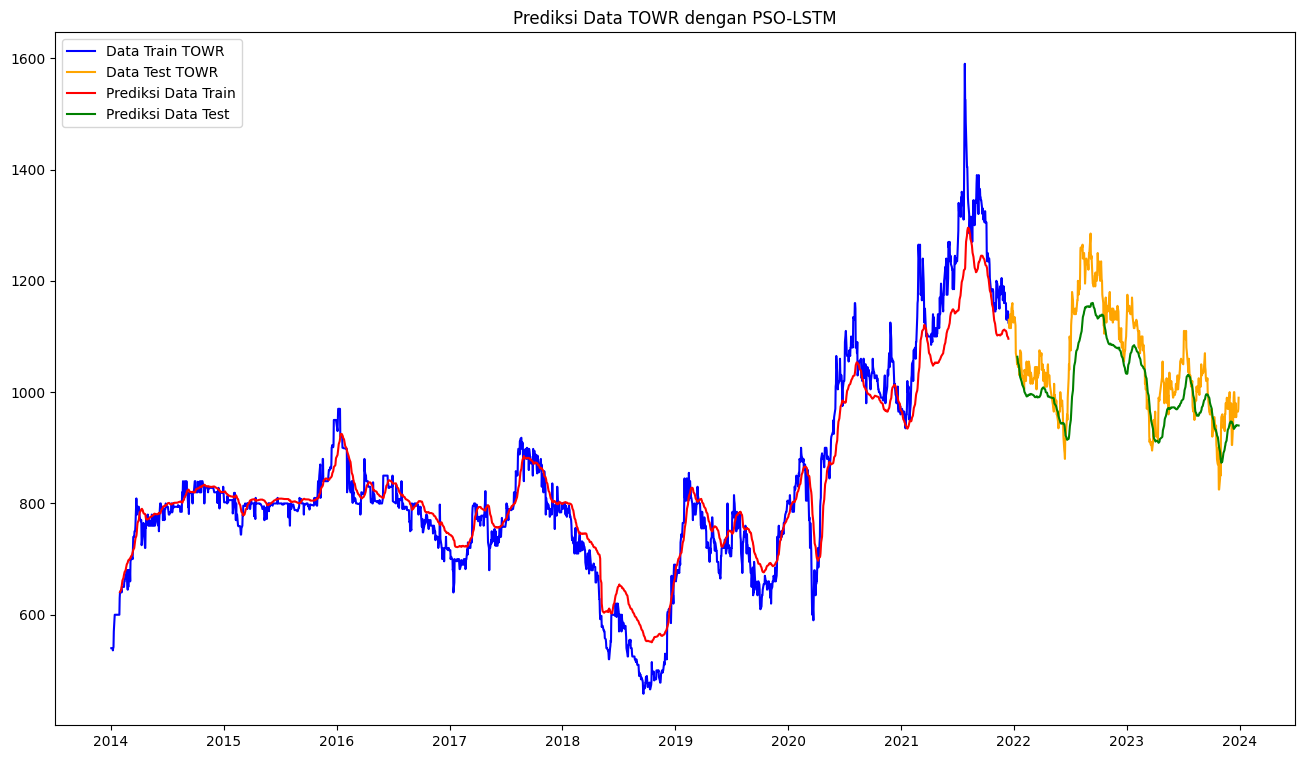

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_psolstm = data_towr[18 + 1:int(split_data)]
data_test_psolstm = data_towr[18 + 1 + int(split_data):]

#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="blue", label='Data Train TOWR')
plt.plot(df_test_towr, color="orange", label='Data Test TOWR')
plt.plot(data_train_psolstm.index, y_train_pred_psolstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_psolstm.index, y_test_pred_psolstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TOWR dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/towr/plot_psolstm_3.png'
plt.savefig(plot_psolstm)
plt.show()

---
## **GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_towr, df_test_towr):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_towr_norm = scaler.fit_transform(df_train_towr.values.reshape(-1,1))
  test_data_towr_norm = scaler.transform(df_test_towr.values.reshape(-1,1))
  return scaler, train_data_towr_norm, test_data_towr_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_towr_norm, test_data_towr_norm = normalize_data(df_train_towr, df_test_towr)

####**Hyperparameter tuning**

In [ ]:
params = (20, 50, 10, 32)
window_size_gru = int(params[0])
hidden_layer_gru = int( params[1])
epochs_gru = int( params[2])
batch_size_gru = int( params[3])
print('Window size: ', window_size_gru)
print('Hidden layer: ', hidden_layer_gru)
print('Epochs: ', epochs_gru)
print('Batch Size: ', batch_size_gru)

Window size:  20
Hidden layer:  50
Epochs:  10
Batch Size:  32


In [ ]:
X_train_gru, Y_train_gru = prepare_dataset(train_data_towr_norm, window_size_gru)
X_test_gru, Y_test_gru = prepare_dataset(test_data_towr_norm, window_size_gru)
print("X_train: ", X_train_gru.shape)
print("Y_train: ", Y_train_gru.shape)
print("X_test: ", X_test_gru.shape)
print("Y_test", Y_test_gru.shape)

X_train:  (1964, 20, 1)
Y_train:  (1964, 1)
X_test:  (476, 20, 1)
Y_test (476, 1)


In [ ]:
start_time = time.time()
#GRU model
final_model_gru = Sequential()
final_model_gru.add(GRU(units=int(hidden_layer_gru), input_shape=(X_train_gru.shape[1], 1),
                 activation='tanh', dropout=0.2))
final_model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

#Train model
final_model_gru.fit(X_train_gru, Y_train_gru, epochs=int(epochs_gru), batch_size=int(batch_size_gru),
            validation_data=(X_test_gru, Y_test_gru), callbacks=[early_stopping])
end_time = time.time()

#Predictions
y_train_pred_gru = final_model_gru.predict(X_train_gru)
y_test_pred_gru = final_model_gru.predict(X_test_gru)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0926 - val_loss: 0.0882
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0274 - val_loss: 0.0224
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0142 - val_loss: 0.0131
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0157 - val_loss: 0.0135
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0136 - val_loss: 0.0143
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0133 - val_loss: 0.0153
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0143 - val_loss: 0.0137
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.reshape(-1,1))
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru.reshape(-1,1))
Y_train_gru = scaler.inverse_transform(Y_train_gru.reshape(-1,1))
Y_test_gru = scaler.inverse_transform(Y_test_gru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_towr, prediksi):
    return np.mean(np.abs((df_test_towr - prediksi) / df_test_towr)) * 100

#Evaluasi Train Data
r2_train_gru = r2_score(Y_train_gru, y_train_pred_gru)
rmse_train_gru = np.sqrt(mse(Y_train_gru, y_train_pred_gru))
mape_train_gru = mape(Y_train_gru, y_train_pred_gru)
print('R2 pada Train Data :', r2_train_gru)
print('RMSE pada Train Data :', rmse_train_gru)
print('MAPE pada Train Data :', mape_train_gru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_gru = r2_score(Y_test_gru, y_test_pred_gru)
rmse_test_gru = np.sqrt(mse(Y_test_gru, y_test_pred_gru))
mape_test_gru = mape(Y_test_gru, y_test_pred_gru)
print('R2 pada Test Data :', r2_test_gru)
print('RMSE pada Test Data :', rmse_test_gru)
print('MAPE pada Test Data :', mape_test_gru)
print("Training time: "  + str(end_time - start_time))

In [ ]:
params_gru = {
    'Window Size': window_size_gru,
    'Hidden Layers': hidden_layer_gru,
    'Epochs': epochs_gru,
    'Batch Size': batch_size_gru,
    'R2 Train': r2_train_gru,
    'RMSE Train': rmse_train_gru,
    'MAE Train': mae_train_gru,
    'MAPE Train': mape_train_gru,
    'R2 Test': r2_test_gru,
    'RMSE Test': rmse_test_gru,
    'MAE Test': mae_test_gru,
    'MAPE Test': mape_test_gru
}

results_gru = pd.DataFrame([params_gru])
folder_gru = '/content/drive/My Drive/skripsi/gru/towr/gru_results.csv'
results_gru.to_csv(folder_gru, index=False, mode='a',header=False)
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/towr/gru_results.csv')
results_gru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.900306,58.043596,40.360489,5.347857,0.428559,70.902298,62.189399,5.704220
1,10,50,10,32,0.861001,68.536978,48.165623,6.355639,0.160264,85.950004,76.803412,7.052672
2,15,25,10,32,0.884203,62.515780,44.831520,5.986224,0.389891,73.375663,64.061389,5.871484
3,15,50,10,32,0.837447,74.069192,52.432674,6.954553,0.066636,90.755693,80.096637,7.354865
4,20,25,10,32,0.862925,67.987780,46.926309,6.133551,0.151564,86.932427,77.472601,7.115229
5,20,50,10,32,0.859092,68.931644,47.773007,6.287946,0.146018,87.216076,77.420915,7.113610


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_gru = data_towr[window_size_gru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_gru.index,  'Data Train': data_train_gru.values})
prediksi_train_gru = pd.DataFrame({'Prediksi Data Train GRU':  y_train_pred_gru.flatten()})
tabel_prediksi_train_gru = pd.concat([tabel_data_train, prediksi_train_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/towr/train/gru_6.csv'
tabel_prediksi_train_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_train_gru

,Date,Data Train,Prediksi Data Train GRU
0,2014-02-04,640.0,684.477722
1,2014-02-05,650.0,689.276306
2,2014-02-06,650.0,693.091797
3,2014-02-07,650.0,696.877075
4,2014-02-10,650.0,700.192139
...,...,...,...
1959,2021-12-08,1130.0,1055.493164
1960,2021-12-09,1135.0,1051.788208
1961,2021-12-10,1145.0,1047.223633
1962,2021-12-13,1145.0,1043.297119


In [ ]:
split_data = data_towr.shape[0] * 0.8
data_test_gru = data_towr[window_size_gru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_gru.index, 'Data Test': data_test_gru.values})
prediksi_test_gru = pd.DataFrame({'Prediksi Data Test GRU':  y_test_pred_gru.flatten()})
tabel_prediksi_test_gru = pd.concat([tabel_data_test, prediksi_test_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/towr/test/gru_6.csv'
tabel_prediksi_test_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_test_gru

,Date,Data Test,Prediksi Data Test GRU
0,2022-01-14,1045.0,1000.204529
1,2022-01-17,1050.0,994.945740
2,2022-01-18,1045.0,990.095520
3,2022-01-19,1030.0,986.160828
4,2022-01-20,1035.0,982.761414
...,...,...,...
471,2023-12-21,955.0,921.317993
472,2023-12-22,965.0,922.164124
473,2023-12-27,965.0,921.306213
474,2023-12-28,970.0,920.405945


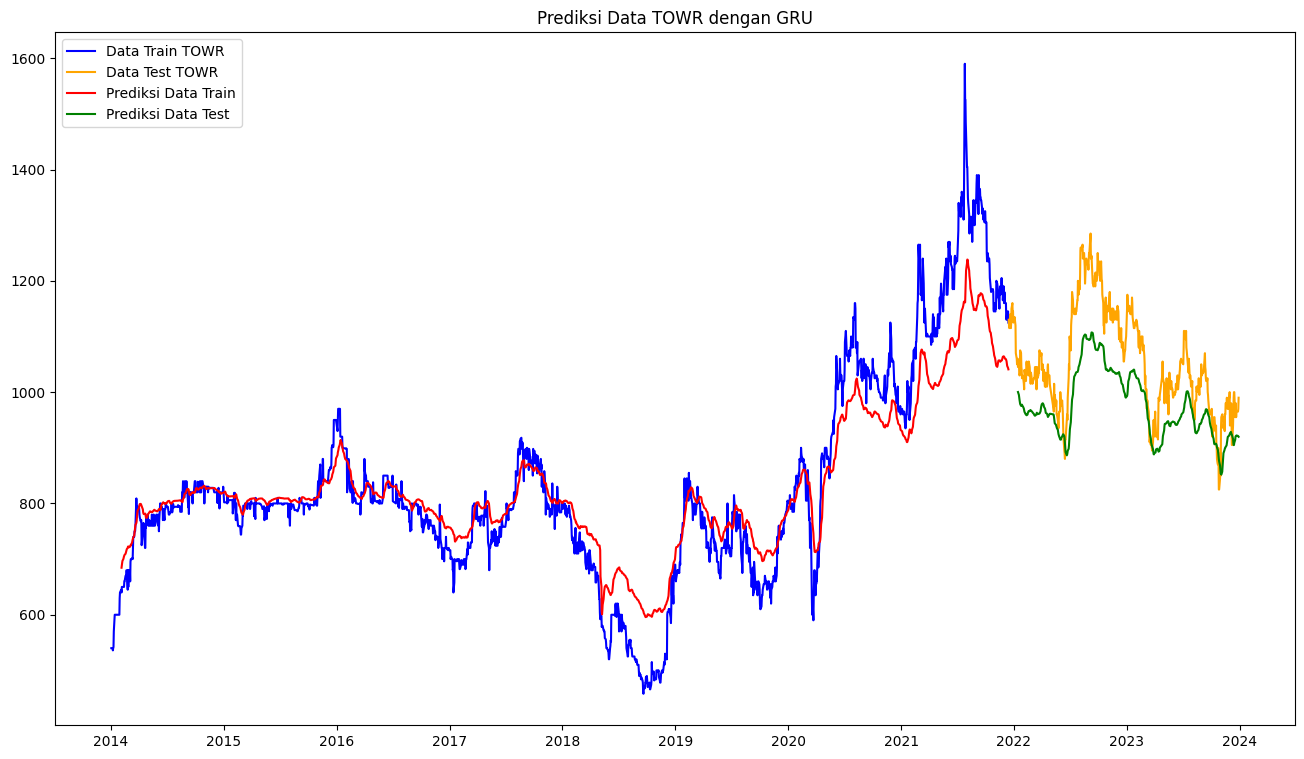

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_gru = data_towr[20 + 1:int(split_data)]
data_test_gru = data_towr[20 + 1 + int(split_data):]

#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="blue", label='Data Train TOWR')
plt.plot(df_test_towr, color="orange", label='Data Test TOWR')
plt.plot(data_train_gru.index, y_train_pred_gru, color="red", label='Prediksi Data Train')
plt.plot(data_test_gru.index, y_test_pred_gru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TOWR dengan GRU')
plt.legend(loc="upper left")
plot_gru = '/content/drive/My Drive/skripsi/gru/towr/plot_gru_6.png'
plt.savefig(plot_gru)
plt.show()

---
## **PSO-GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_towr, df_test_towr):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_towr_norm = scaler.fit_transform(df_train_towr.values.reshape(-1,1))
  test_data_towr_norm = scaler.transform(df_test_towr.values.reshape(-1,1))
  return scaler, train_data_towr_norm, test_data_towr_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-GRU**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_gru(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params

  print('window_size', window_size, ', hidden_layers', hidden_layers,
          ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #GRU model
  model = Sequential()
  model.add(GRU(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_towr_norm, test_data_towr_norm = normalize_data(df_train_towr, df_test_towr)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_towr_norm, lb[0])
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_towr_norm, lb[0])
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psogru, best_value_psogru = pso(objective_function_gru, lb, ub, args=(X_train_psogru, Y_train_psogru, scaler, X_test_psogru, Y_test_psogru), swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psogru)
print('RMSE:', best_value_psogru)

window_size 17.979138025242406 , hidden_layers 40.98099772741146 , epochs 6.607061195407892 , batch_size 30.05007892030038
Epoch 1/6
66/66 [==============================] - 4s 15ms/step - loss: 0.2600 - val_loss: 0.3119
Epoch 2/6
66/66 [==============================] - 1s 14ms/step - loss: 0.1154 - val_loss: 0.1305
Epoch 3/6
66/66 [==============================] - 1s 15ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 4/6
66/66 [==============================] - 1s 17ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 5/6
66/66 [==============================] - 1s 18ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 6/6
16/16 [==============================] - 0s 2ms/step
Validation RMSE:  0.06640582640183237 

window_size 19.530553546865725 , hidden_layers 37.24391654026899 , epochs 7.679465689993148 , batch_size 29.691557699631076
Epoch 1/7
69/69 [==============================] - 3s 14ms/step - loss: 0.2968 - val_loss: 0.3799
Epoch 2/7
69/69 [==============================] - 1s 8ms/step

In [ ]:
optimal_window_size_psogru = int(best_params_psogru[0])
optimal_hidden_layer_psogru = int(best_params_psogru[1])
optimal_epochs_psogru = int(best_params_psogru[2])
optimal_batch_size_psogru = int(best_params_psogru[3])
print('Optimal window size: ', optimal_window_size_psogru)
print('Optimal hidden layer: ', optimal_hidden_layer_psogru)
print('Optimal epoch: ', optimal_epochs_psogru)
print('Optimal batch size: ', optimal_batch_size_psogru)

Optimal window size:  17
Optimal hidden layer:  45
Optimal epoch:  8
Optimal batch size:  4


In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_towr_norm, optimal_window_size_psogru)
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_towr_norm, optimal_window_size_psogru)
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1967, 17, 1)
Y_train:  (1967, 1)
X_test:  (479, 17, 1)
Y_test (479, 1)


In [ ]:
final_model_psogru = Sequential()
final_model_psogru.add(GRU(units=optimal_hidden_layer_psogru, input_shape=(X_train_psogru.shape[1], 1), activation='tanh', dropout=0.2))
final_model_psogru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psogru.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psogru.fit(X_train_psogru, Y_train_psogru, epochs=optimal_epochs_psogru, batch_size=optimal_batch_size_psogru, validation_data=(X_test_psogru, Y_test_psogru))
y_train_pred_psogru = final_model_psogru.predict(X_train_psogru)
y_test_pred_psogru = final_model_psogru.predict(X_test_psogru)

Epoch 1/8
492/492 [==============================] - 8s 12ms/step - loss: 0.0214 - val_loss: 0.0040
Epoch 2/8
492/492 [==============================] - 4s 9ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 3/8
492/492 [==============================] - 4s 9ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 4/8
492/492 [==============================] - 6s 11ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 5/8
492/492 [==============================] - 4s 8ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/8
492/492 [==============================] - 4s 8ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 7/8
492/492 [==============================] - 5s 10ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 8/8
15/15 [==============================] - 0s 3ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psogru = scaler.inverse_transform(y_train_pred_psogru.reshape(-1,1))
y_test_pred_psogru = scaler.inverse_transform(y_test_pred_psogru.reshape(-1,1))
Y_train_psogru = scaler.inverse_transform(Y_train_psogru.reshape(-1,1))
Y_test_psogru = scaler.inverse_transform(Y_test_psogru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_towr, prediksi):
    return np.mean(np.abs((df_test_towr - prediksi) / df_test_towr)) * 100

#Evaluasi Train Data
r2_train_psogru = r2_score(Y_train_psogru, y_train_pred_psogru)
rmse_train_psogru = np.sqrt(mse(Y_train_psogru, y_train_pred_psogru))
mae_train_psogru = mae(Y_train_psogru, y_train_pred_psogru)
mape_train_psogru = mape(Y_train_psogru, y_train_pred_psogru)
print('R2 pada Train data :', r2_train_psogru)
print('RMSE pada Train data :', rmse_train_psogru)
print('MAE pada Train data :', mae_train_psogru)
print('MAPE pada Train data :', mape_train_psogru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psogru = r2_score(Y_test_psogru, y_test_pred_psogru)
rmse_test_psogru = np.sqrt(mse(Y_test_psogru, y_test_pred_psogru))
mae_test_psogru = mae(Y_test_psogru, y_test_pred_psogru)
mape_test_psogru = mape(Y_test_psogru, y_test_pred_psogru)
print('R2 pada Test data :', r2_test_psogru)
print('RMSE pada Test data :', rmse_test_psogru)
print('MAE pada Test data :', mae_test_psogru)
print('MAPE pada Test data :', mape_test_psogru)
print("Training time: "  + str(end_time - start_time))

R2 pada Train data : 0.8895134694918873
RMSE pada Train data : 61.0494968023863
MAE pada Train data : 41.51421365122172
MAPE pada Train data : 5.207854712363352
------------------------------------------
R2 pada Test data : 0.17328042282312917
RMSE pada Test data : 85.54419433995362
MAE pada Test data : 75.3565770668874
MAPE pada Test data : 6.971249204401389
Training time: 1021.1026067733765


In [ ]:
params_psogru = {
    'Window Size': optimal_window_size_psogru,
    'Hidden Layers': optimal_hidden_layer_psogru,
    'Epochs': optimal_epochs_psogru,
    'Batch Size': optimal_batch_size_psogru,
    'R2 Train': r2_train_psogru,
    'RMSE Train': rmse_train_psogru,
    'MAE Train': mae_train_psogru,
    'MAPE Train': mape_train_psogru,
    'R2 Test': r2_test_psogru,
    'RMSE Test': rmse_test_psogru,
    'MAE Test': mae_test_psogru,
    'MAPE Test': mape_test_psogru
}

results_psogru = pd.DataFrame([params_psogru])
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/towr/psogru_results.csv'
results_psogru.to_csv(folder_psogru, index=False, mode='a', header=False)
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/towr/psogru_results.csv')
results_psogru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,18,37,2,1,0.897117,58.903739,39.674666,5.295691,0.410771,72.294431,61.859524,5.693641
1,10,43,10,8,0.880056,63.666089,43.845161,5.845969,0.285042,79.307601,69.898701,6.430270
2,17,45,8,4,0.889513,61.049497,41.514214,5.207855,0.173280,85.544194,75.356577,6.971249


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_psogru = data_towr[optimal_window_size_psogru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psogru.index,  'Data Train': data_train_psogru.values})
prediksi_train_psogru = pd.DataFrame({'Prediksi Data Train PSO-GRU':  y_train_pred_psogru.flatten()})
tabel_prediksi_train_psogru = pd.concat([tabel_data_train, prediksi_train_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/towr/train/psogru_3.csv'
tabel_prediksi_train_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_train_psogru

,Date,Data Train,Prediksi Data Train PSO-GRU
0,2014-01-29,630.0,628.880615
1,2014-01-30,640.0,630.850098
2,2014-02-03,645.0,634.988831
3,2014-02-04,640.0,639.136047
4,2014-02-05,650.0,643.158203
...,...,...,...
1962,2021-12-08,1130.0,1074.580811
1963,2021-12-09,1135.0,1072.279541
1964,2021-12-10,1145.0,1070.198730
1965,2021-12-13,1145.0,1067.566406


In [ ]:
split_data = data_towr.shape[0] * 0.8
data_test_psogru = data_towr[optimal_window_size_psogru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psogru.index, 'Data Test': data_test_psogru.values})
prediksi_test_psogru = pd.DataFrame({'Prediksi Data Test PSO-GRU':  y_test_pred_psogru.flatten()})
tabel_prediksi_test_psogru = pd.concat([tabel_data_test, prediksi_test_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/towr/test/psogru_3.csv'
tabel_prediksi_test_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_test_psogru

,Date,Data Test,Prediksi Data Test PSO-GRU
0,2022-01-11,1050.0,1035.99110
1,2022-01-12,1050.0,1032.31920
2,2022-01-13,1060.0,1028.14210
3,2022-01-14,1045.0,1023.83160
4,2022-01-17,1050.0,1019.34210
...,...,...,...
474,2023-12-21,955.0,907.44640
475,2023-12-22,965.0,908.55870
476,2023-12-27,965.0,907.73474
477,2023-12-28,970.0,907.73550


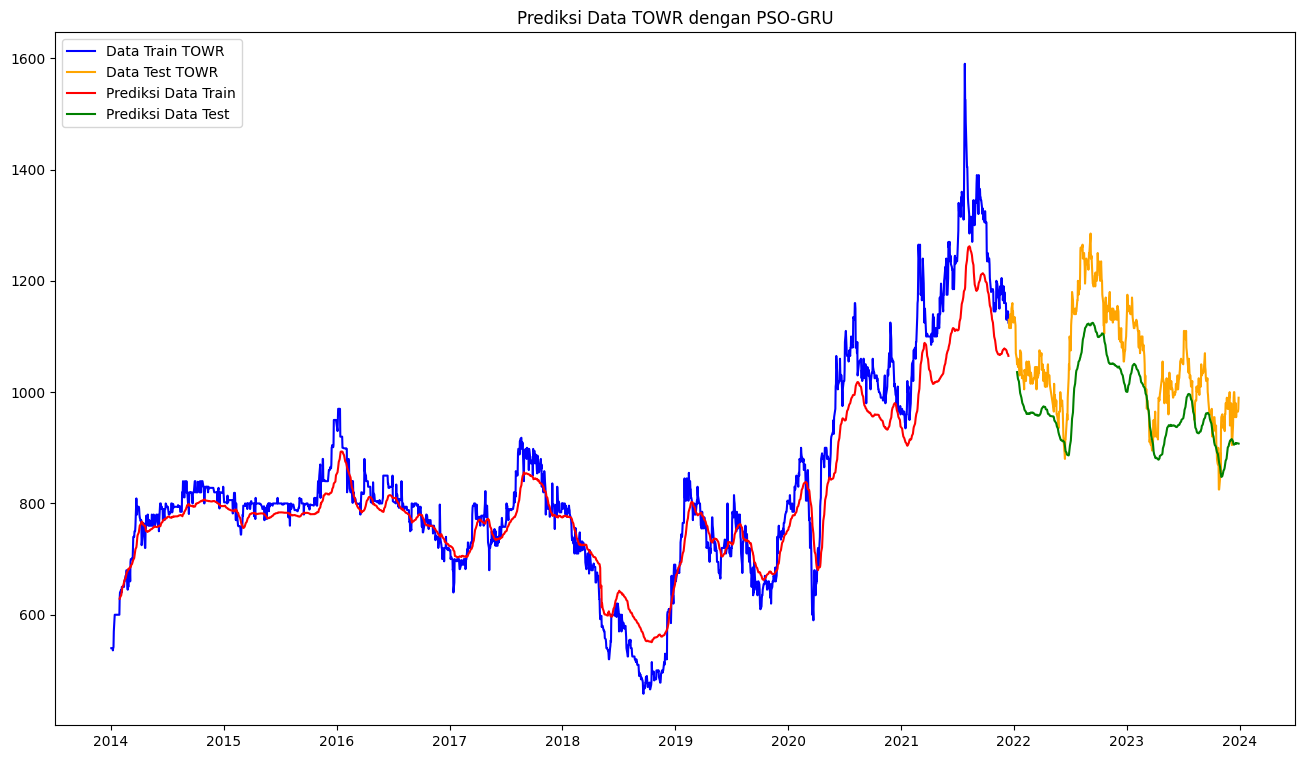

In [ ]:
split_data = data_towr.shape[0] * 0.8
data_train_psogru = data_towr[17 + 1:int(split_data)]
data_test_psogru = data_towr[17 + 1 + int(split_data):]

#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="blue", label='Data Train TOWR')
plt.plot(df_test_towr, color="orange", label='Data Test TOWR')
plt.plot(data_train_psogru.index, y_train_pred_psogru, color="red", label='Prediksi Data Train')
plt.plot(data_test_psogru.index, y_test_pred_psogru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TOWR dengan PSO-GRU')
plt.legend(loc="upper left")
plot_psogru = '/content/drive/My Drive/skripsi/pso-gru/towr/plot_psogru_3.png'
plt.savefig(plot_psogru)
plt.show()

---
## **Comparison Auto ARIMA vs LSTM vs PSO-LSTM vs GRU vs PSO-GRU**
---

### **Hyperparameter**

In [ ]:
results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/towr/lstm_results.csv')
results_lstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.867797,66.840445,46.313268,6.154528,0.228324,82.393360,72.398970,6.649889
1,10,50,10,32,0.882845,62.921521,42.295018,5.616402,0.270886,80.088874,69.501745,6.407421
2,15,25,10,32,0.891074,60.632578,42.511711,5.691017,0.460277,69.013475,57.877025,5.305960
3,15,50,10,32,0.913273,54.102658,37.108530,5.050751,0.580598,60.836447,50.319848,4.643440
4,20,25,10,32,0.879255,63.809668,46.341643,6.284630,0.476870,68.261703,56.757114,5.205382
5,20,50,10,32,0.943047,43.823892,30.212063,4.273980,0.796288,42.597112,32.957487,3.117187
6,20,50,10,32,0.815122,78.421787,54.121604,6.337616,-0.496908,115.470173,104.870613,9.684108


In [ ]:
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/towr/psolstm_results.csv')
results_psolstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,15,49,10,28,0.913215,54.120570,36.454805,4.986983,0.572068,61.451983,50.657135,4.689108
1,16,35,3,25,0.904863,56.657597,38.361991,5.201159,0.506647,66.016421,55.094935,5.083568
2,18,50,4,32,0.922176,51.230499,34.544298,4.682639,0.614493,58.476160,48.400218,4.468277
3,12,32,8,18,0.716511,97.194476,66.642679,8.103779,-1.113231,136.416507,125.348155,11.565231


In [ ]:
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/towr/gru_results.csv')
results_gru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.900306,58.043596,40.360489,5.347857,0.428559,70.902298,62.189399,5.704220
1,10,50,10,32,0.861001,68.536978,48.165623,6.355639,0.160264,85.950004,76.803412,7.052672
2,15,25,10,32,0.884203,62.515780,44.831520,5.986224,0.389891,73.375663,64.061389,5.871484
3,15,50,10,32,0.837447,74.069192,52.432674,6.954553,0.066636,90.755693,80.096637,7.354865
4,20,25,10,32,0.862925,67.987780,46.926309,6.133551,0.151564,86.932427,77.472601,7.115229
5,20,50,10,32,0.859092,68.931644,47.773007,6.287946,0.146018,87.216076,77.420915,7.113610
6,20,50,10,32,0.647164,108.337946,78.349731,9.765884,-1.205959,140.175158,127.459613,11.721197


In [ ]:
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/towr/psogru_results.csv')
results_psogru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,18,37,2,1,0.897117,58.903739,39.674666,5.295691,0.410771,72.294431,61.859524,5.693641
1,10,43,10,8,0.880056,63.666089,43.845161,5.845969,0.285042,79.307601,69.898701,6.430270
2,17,45,8,4,0.889513,61.049497,41.514214,5.207855,0.173280,85.544194,75.356577,6.971249
3,12,25,9,18,0.620341,112.478766,81.042215,10.093345,-1.461471,147.228117,134.889367,12.413999


In [ ]:
tabel_hyperparameter = pd.DataFrame({'Model' : ['LSTM', 'PSO-LSTM', 'GRU', 'PSO-GRU'],
                                     'Window Size' : [results_lstm.loc[5, 'Window Size'], results_psolstm.loc[2, 'Window Size'], results_gru.loc[0, 'Window Size'], results_psogru.loc[0, 'Window Size']],
                                     'Hidden Layers' : [results_lstm.loc[5, 'Hidden Layers'], results_psolstm.loc[2, 'Hidden Layers'],  results_gru.loc[0, 'Hidden Layers'], results_psogru.loc[0, 'Hidden Layers']],
                                     'Epochs' : [results_lstm.loc[5, 'Epochs'], results_psolstm.loc[2, 'Epochs'], results_gru.loc[0, 'Epochs'], results_psogru.loc[0, 'Epochs']],
                                     'Batch Size' : [results_lstm.loc[5, 'Batch Size'], results_psolstm.loc[2, 'Batch Size'], results_gru.loc[0, 'Batch Size'], results_psogru.loc[0, 'Batch Size']]})
tabel_hyperparameter

,Model,Window Size,Hidden Layers,Epochs,Batch Size
0,LSTM,20,50,10,32
1,PSO-LSTM,18,50,4,32
2,GRU,10,25,10,32
3,PSO-GRU,18,37,2,1


### **Evaluasi Model**

In [ ]:
tabel_comparison_evaluasi = pd.DataFrame({'Model' : ['R2', 'RMSE', 'MAPE'],
                                          'Train Auto ARIMA' : [r2_train_autoarima, rmse_train_autoarima, mape_train_autoarima],
                                          'Test Auto ARIMA' : [r2_test_autoarima, rmse_test_autoarima, mape_test_autoarima],
                                          'Train LSTM' : [results_lstm.loc[5, 'R2 Train'], results_lstm.loc[5, 'RMSE Train'], results_lstm.loc[5, 'MAPE Train']],
                                          'Test LSTM': [results_lstm.loc[5, 'R2 Test'], results_lstm.loc[5, 'RMSE Test'], results_lstm.loc[5, 'MAPE Test']],
                                          'Train PSO-LSTM' : [results_psolstm.loc[2, 'R2 Train'], results_psolstm.loc[2, 'RMSE Train'], results_psolstm.loc[2, 'MAPE Train']],
                                          'Test PSO-LSTM': [results_psolstm.loc[2, 'R2 Test'], results_psolstm.loc[2, 'RMSE Test'], results_psolstm.loc[2, 'MAPE Test']],
                                          'Train GRU' : [results_gru.loc[0, 'R2 Train'], results_gru.loc[0, 'RMSE Train'], results_gru.loc[0, 'MAPE Train']],
                                          'Test GRU': [results_gru.loc[0, 'R2 Test'], results_gru.loc[0, 'RMSE Test'], results_gru.loc[0, 'MAPE Test']],
                                          'Train PSO-GRU' : [results_psogru.loc[0, 'R2 Train'], results_psogru.loc[0, 'RMSE Train'], results_psogru.loc[0, 'MAPE Train']],
                                          'Test PSO-GRU': [results_psogru.loc[0, 'R2 Test'], results_psogru.loc[0, 'RMSE Test'], results_psogru.loc[0, 'MAPE Test']],
                                 })
tabel_comparison_evaluasi

,Model,Train Auto ARIMA,Test Auto ARIMA,Train LSTM,Test LSTM,Train PSO-LSTM,Test PSO-LSTM,Train GRU,Test GRU,Train PSO-GRU,Test PSO-GRU
0,R2,0.986250,-0.609516,0.943047,0.796288,0.922176,0.614493,0.900306,0.428559,0.897117,0.410771
1,RMSE,21.480558,118.600400,43.823892,42.597112,51.230499,58.476160,58.043596,70.902298,58.903739,72.294431
2,MAPE,1.365188,9.988069,4.273980,3.117187,4.682639,4.468277,5.347857,5.704220,5.295691,5.693641


### **Fitted Values**

In [ ]:
fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_towr_fitted.csv', usecols=['Date','Fitted Values'])
fitted_autoarima['Date'] = pd.to_datetime(fitted_autoarima['Date'])
fitted_autoarima['Date'] = fitted_autoarima['Date'].dt.date
fitted_autoarima.set_index('Date', inplace=True)

fitted_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/towr/train/lstm_6.csv', usecols=['Date','Prediksi Data Train LSTM'])
fitted_lstm['Date'] = pd.to_datetime(fitted_lstm['Date'], format='%Y-%m-%d')
fitted_lstm['Date'] = fitted_lstm['Date'].dt.date
fitted_lstm.set_index('Date', inplace=True)

fitted_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/towr/train/psolstm_3.csv', usecols=['Date','Prediksi Data Train PSO-LSTM'])
fitted_psolstm['Date'] = pd.to_datetime(fitted_psolstm['Date'])
fitted_psolstm['Date'] = fitted_psolstm['Date'].dt.date
fitted_psolstm.set_index('Date', inplace=True)

fitted_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/towr/train/gru_1.csv', usecols=['Date','Prediksi Data Train GRU'])
fitted_gru['Date'] = pd.to_datetime(fitted_gru['Date'])
fitted_gru['Date'] = fitted_gru['Date'].dt.date
fitted_gru.set_index('Date', inplace=True)

fitted_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/towr/train/psogru_1.csv', usecols=['Date','Prediksi Data Train PSO-GRU'])
fitted_psogru['Date'] = pd.to_datetime(fitted_psogru['Date'])
fitted_psogru['Date'] = fitted_psogru['Date'].dt.date
fitted_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_train_towr, fitted_autoarima,  fitted_lstm, fitted_psolstm, fitted_gru, fitted_psogru], axis = 1)
folder_data_tlkm = '/content/drive/My Drive/skripsi/fitted_data_tlkm.csv'
tabel_comparison_prediksi.to_csv(folder_data_tlkm, index=True, mode='a')
tabel_comparison_prediksi

,TOWR,Fitted Values,Prediksi Data Train LSTM,Prediksi Data Train PSO-LSTM,Prediksi Data Train GRU,Prediksi Data Train PSO-GRU
2014-01-02,540.0,1.000000,NaN,NaN,NaN,NaN
2014-01-03,540.0,540.000000,NaN,NaN,NaN,NaN
2014-01-06,540.0,540.000000,NaN,NaN,NaN,NaN
2014-01-07,536.0,540.000000,NaN,NaN,NaN,NaN
2014-01-08,540.0,536.752957,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-08,1130.0,1139.779993,1146.6237,1107.2540,1073.4340,1085.5026
2021-12-09,1135.0,1131.840175,1143.7406,1104.2888,1067.4207,1082.8639
2021-12-10,1145.0,1134.402698,1140.1646,1100.9554,1061.4908,1079.5796
2021-12-13,1145.0,1142.991502,1136.7931,1098.2630,1057.5663,1076.5166


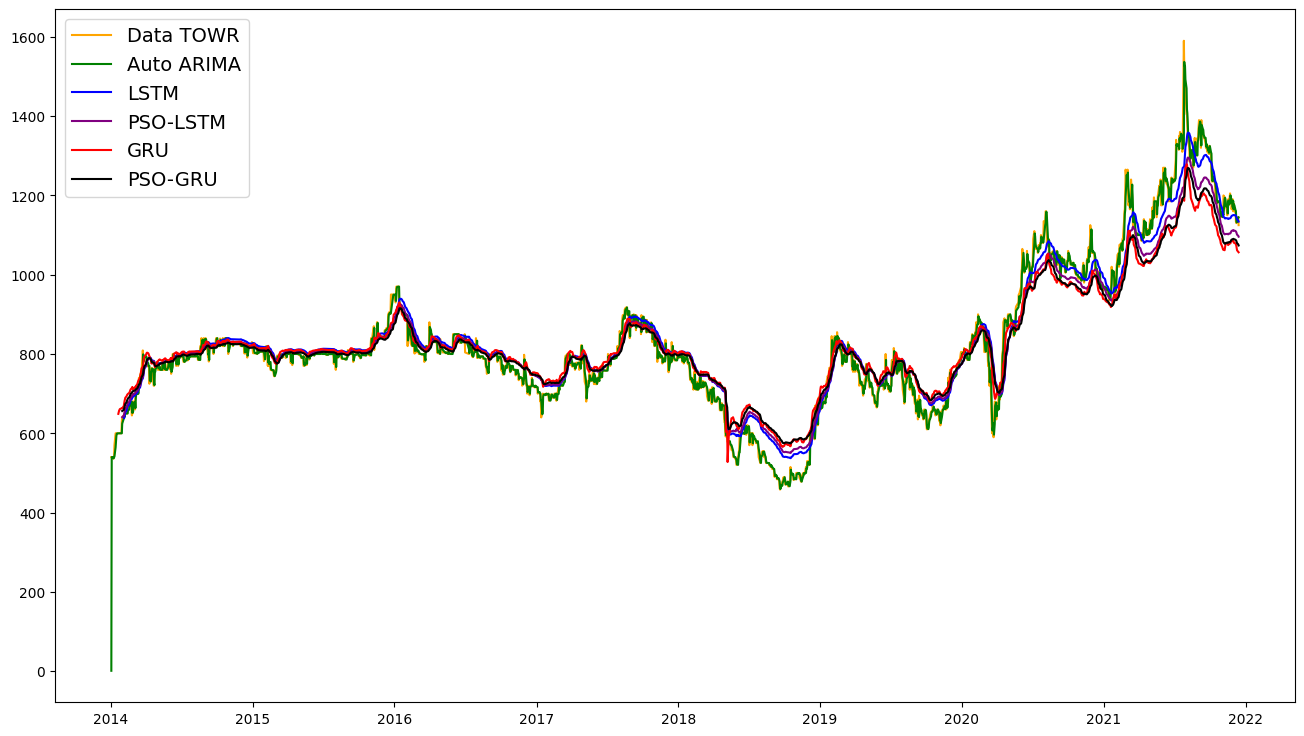

In [ ]:
#plot the fitted values
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_towr, color="orange", label='Data TOWR')
plt.plot(fitted_autoarima, color="green", label='Auto ARIMA')
plt.plot(fitted_lstm, color="blue", label='LSTM')
plt.plot(fitted_psolstm, color="purple", label='PSO-LSTM')
plt.plot(fitted_gru, color="red", label='GRU')
plt.plot(fitted_psogru, color="black", label='PSO-GRU')
plt.legend(loc="upper left", fontsize=14)
plt.show()

### **Prediksi**

In [ ]:
prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_towr_results.csv', usecols=['Date','Prediksi Auto ARIMA'])
prediksi_autoarima['Date'] = pd.to_datetime(prediksi_autoarima['Date'], format='%Y-%m-%d')
prediksi_autoarima['Date'] = prediksi_autoarima['Date'].dt.date
prediksi_autoarima.set_index('Date', inplace=True)

prediksi_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/towr/test/lstm_6.csv', usecols=['Date','Prediksi Data Test LSTM'])
prediksi_lstm['Date'] = pd.to_datetime(prediksi_lstm['Date'])
prediksi_lstm['Date'] = prediksi_lstm['Date'].dt.date
prediksi_lstm.set_index('Date', inplace=True)

prediksi_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/towr/test/psolstm_3.csv', usecols=['Date','Prediksi Data Test PSO-LSTM'])
prediksi_psolstm['Date'] = pd.to_datetime(prediksi_psolstm['Date'])
prediksi_psolstm['Date'] = prediksi_psolstm['Date'].dt.date
prediksi_psolstm.set_index('Date', inplace=True)

prediksi_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/towr/test/gru_1.csv', usecols=['Date','Prediksi Data Test GRU'])
prediksi_gru['Date'] = pd.to_datetime(prediksi_gru['Date'])
prediksi_gru['Date'] = prediksi_gru['Date'].dt.date
prediksi_gru.set_index('Date', inplace=True)

prediksi_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/towr/test/psogru_1.csv', usecols=['Date','Prediksi Data Test PSO-GRU'])
prediksi_psogru['Date'] = pd.to_datetime(prediksi_psogru['Date'])
prediksi_psogru['Date'] = prediksi_psogru['Date'].dt.date
prediksi_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_test_towr, prediksi_autoarima,  prediksi_lstm, prediksi_psolstm, prediksi_gru, prediksi_psogru], axis = 1)
folder_data_towr = '/content/drive/My Drive/skripsi/prediksi_data_towr.csv'
tabel_comparison_prediksi.to_csv(folder_data_towr, index=True, mode='a')
tabel_comparison_prediksi

,TOWR,Prediksi Auto ARIMA,Prediksi Data Test LSTM,Prediksi Data Test PSO-LSTM,Prediksi Data Test GRU,Prediksi Data Test PSO-GRU
2021-12-15,1130.0,1128.678738,NaN,NaN,NaN,NaN
2021-12-16,1120.0,1128.678738,NaN,NaN,NaN,NaN
2021-12-17,1115.0,1128.678738,NaN,NaN,NaN,NaN
2021-12-20,1140.0,1128.678738,NaN,NaN,NaN,NaN
2021-12-21,1140.0,1128.678738,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-21,955.0,1128.678738,957.91815,939.53880,934.86180,926.65906
2023-12-22,965.0,1128.678738,958.89667,940.71375,936.30804,927.95074
2023-12-27,965.0,1128.678738,958.88165,940.23737,933.78880,928.03784
2023-12-28,970.0,1128.678738,958.72220,940.14620,932.91410,928.02325


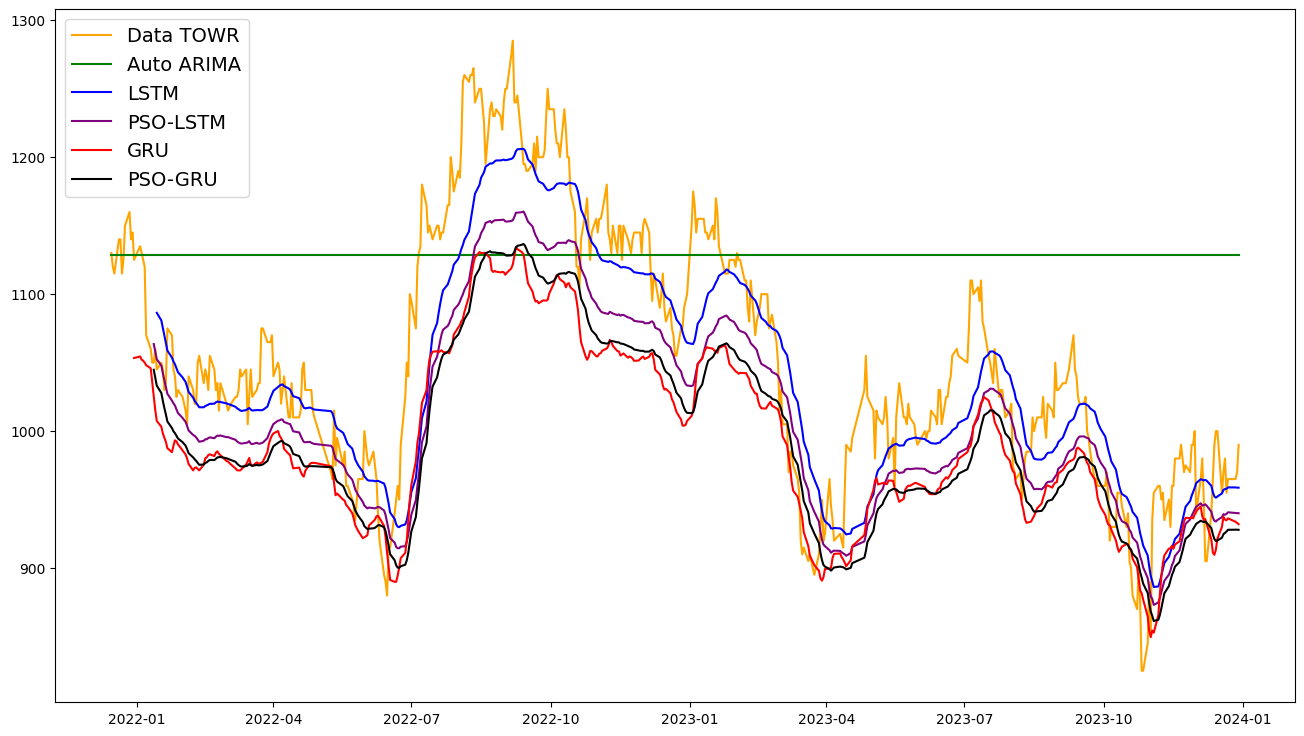

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_test_towr, color="orange", label='Data TOWR')
plt.plot(prediksi_autoarima, color="green", label='Auto ARIMA')
plt.plot(prediksi_lstm, color="blue", label='LSTM')
plt.plot(prediksi_psolstm, color="purple", label='PSO-LSTM')
plt.plot(prediksi_gru, color="red", label='GRU')
plt.plot(prediksi_psogru, color="black", label='PSO-GRU')
plt.legend(loc="upper left", fontsize=14)
plt.show()